### Análise dos Covenants Contábeis divulgados pelas empresas listadas na B3 (2010 a 2022)

In [256]:
## bibliotecas usadas
import pandas as pd
import numpy as np
import unicodedata
import os
import re
# visualização
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import dataframe_image as dfi
# análise
from concurrent.futures import ThreadPoolExecutor
from rapidfuzz import fuzz, process



### A análise começou com a coleta manual das notas explicativas publicadas pelas empresas no site da B3 Investidor, como também da Comissão de Valores Mobiliários (CVM).
Após coleta fiz um script para ler todos os pdfs (disponível no github: `link`) e separar em uma pasta todos que citaram covenants ou cláusulas restritivas.

In [257]:
empresas_df = pd.read_excel("Empresas_com_covenants.xlsx")
# empresas_df = pd.read_excel("C:\{estudos}\Covenants - pibic\Covenants-Contabeis\Empresas_com_covenants.xlsx")
empresas_df.head()

,Empresa,Quantidade de Anos
0,Hidrovias do Brasil,11
1,Ambipar Participacoes e Empreendimentos,4
2,Plano & Plano Desenvolvimento Imobiliario SA,4
3,Renner,13
4,B3 SA Brasil Bolsa Balcao,3


In [258]:
empresas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Empresa             282 non-null    object
 1   Quantidade de Anos  282 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.5+ KB


### Selecionando agora a base de dados da análise manual
Empresas que citaram termos como "covenants" ou cláusulas "restritivas" e foram submetidas a análise manual das notas explicativas coletadas.

### Dicionário de Variáveis — Base de Análise Manual dos Covenants

Esta base contém informações extraídas manualmente das notas explicativas de empresas que mencionaram termos como **"covenants"** ou cláusulas **"restritivas"**. As empresas listadas passaram por um processo de verificação e categorização quanto à existência e divulgação dessas cláusulas.

| Coluna                               | Descrição |
|-------------------------------------|-----------|
| **EMPRESA**                         | Nome padronizado da empresa analisada (em letras maiúsculas e sem espaços extras). |
| **ANO**                             | Ano em que foi feita a análise da nota explicativa da empresa. |
| **POSSUI COVENANT**                 | Indica se a empresa possui cláusulas financeiras restritivas (covenants). Valores possíveis: `Sim`, `Não`, `Não encontrado`. |
| **DIVULGOU**                        | Indica se a empresa divulgou informações detalhadas sobre os covenants identificados. Valores possíveis: `Sim`, `Parcial`, `Não`. |
| **Debenture ou Empréstimos e financiamento** | Tipo de contrato relacionado ao covenant. Informa se o covenant foi associado a **debêntures**, **empréstimos e financiamentos** ou outro tipo de instrumento financeiro. |
| **Índice Utilizado**                | Índice financeiro citado na cláusula. Pode ser, por exemplo, `Dívida Líquida/EBITDA`, `Cobertura de Juros`, `Liquidez Corrente`, etc. |
| **Limite**                          | Valor de referência imposto pelo covenant. Pode ser um número absoluto, uma razão financeira ou um percentual. |
| **Violou?**                         | Indica se houve **descumprimento** (violação) do covenant no período analisado. Valores possíveis: `Sim`, `Não`, `Não divulgado`. |

> **Observações Importantes**:
> - Algumas empresas citam o termo **covenant** sem, de fato, detalhar a cláusula ou apresentar as condições contratuais.
> - Em alguns casos, a nota explicativa revela a **existência** do covenant, mas não especifica o **índice, limite ou situação de violação**.



In [259]:
covenants = pd.read_excel("Base Covenants Contabeis.xlsx")
covenants.tail()

,EMPRESA,ANO,POSSUI COVENANT,DIVULGOU,Debenture ou Empréstimos e financiamento,Índice Utilizado,Limite,Violou?
6267,Zamp,2021.0,SIM,SIM,Debêntures,Dívida Líquida/EBITDA,menor ou igual a 3,SIM
6268,Zamp,2022.0,SIM,SIM,Debêntures,Dívida Líquida/EBITDA,menor ou igual a 3,NÃO
6269,Zamp,2022.0,SIM,SIM,Debêntures,Dívida Líquida/EBITDA,menor ou igual a 3,NÃO
6270,Zamp,2023.0,SIM,SIM,Debêntures,Dívida Líquida/EBITDA,menor ou igual a 3,NÃO
6271,Zamp,2023.0,SIM,SIM,Debêntures,Dívida Líquida/EBITDA,menor ou igual a 3,NÃO


In [260]:
covenants['Índice Utilizado'].nunique()

85

In [261]:
covenants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6272 entries, 0 to 6271
Data columns (total 8 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   EMPRESA                                   6272 non-null   object 
 1   ANO                                       6262 non-null   float64
 2   POSSUI COVENANT                           6265 non-null   object 
 3   DIVULGOU                                  5990 non-null   object 
 4   Debenture ou Empréstimos e financiamento  5249 non-null   object 
 5   Índice Utilizado                          5209 non-null   object 
 6   Limite                                    4833 non-null   object 
 7   Violou?                                   4622 non-null   object 
dtypes: float64(1), object(7)
memory usage: 392.1+ KB


> Houve uma redução de 282 empresas para 259 na análise manual porque foi retirada empresas do setor financeiro e que disponibilizaram menos de duas notas explicativas desde 2010

In [262]:
covenants['EMPRESA'].nunique()

259

### Tratamento da base de dados

In [263]:
covenants.dropna(subset=['ANO'], inplace=True)
covenants['ANO'] = covenants['ANO'].astype(int)

# limpeza coluna 'Limite'
valores_unicos = covenants['Limite'].dropna().unique()
valores_unicos

array(['menor ou igual a 3,5', 'menor ou igual a 4,5',
       'maior ou igual a 1,25', 'maior ou igual a 1,2',
       'maior ou igual a 1,3', 'maior ou igual a 1', 'menor ou igual a 3',
       'maior ou igual a 1,1', 'menor ou igual a 2,5',
       'maior ou igual a 1,75', 'menor ou igual a 3,6',
       'maior ou igual a 1,76', 'maior ou igual a 1,5',
       'menor ou igual a 3,75', 'maior ou igual a 1,10',
       'menor ou igual a 5,6', 'maior ou igual a 1,15',
       'menor ou igual a 1,9 bi', 'menor ou igual a 338 mi',
       'menor ou igual a 840 mi', 'menor ou igual a 285 mi',
       'maior ou igual a 20%', 'menor ou igual a 50 mi',
       'maior ou igual a 41 mi', 'menor ou igual a 164 mi',
       'menor ou igual a 225 mi', 'maior ou igual a 1,20',
       'maior ou igual a 3,75', 'menor ou igual a 1,75',
       'menor ou igual a 0,6', 'maior ou igual a 3,50',
       'maior ou igual a 0,6', 'menor ou igual a 2,75',
       'menor ou igual a 2,50', 'menor ou igual a 3,0',
       'men

In [264]:
# Função para normalizar o texto (remove acentos e converte para minúsculo)
def normalizar_texto(texto):
    texto = str(texto).lower().strip()
    texto = texto.replace(',', '.')
    texto = re.sub(r'\s+', ' ', texto)  # remove espaços duplos
    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')
    return texto

# Lista de operadores em regex
operadores_regex = (
    r'(maior ou igual a|maior ou igual|menor ou igual a|menor ou igual|'
    r'maior que|menor que|igual a)'
)

# Função principal
def extrair_limite(texto):
    if pd.isnull(texto):
        return pd.Series([None, None])

    texto_original = texto  # para verificar se tem %
    texto = normalizar_texto(texto)

    # Ignorar se houver unidades monetárias ou palavras irrelevantes
    if any(unidade in texto for unidade in ['r$', 'milhao', 'milhoes', 'mi', 'pl', 'depreciacao', 'amortizacao', 'principal']):
        return pd.Series([None, None])

    # Detectar porcentagem
    tem_porcentagem = '%' in texto_original

    # Regex para operador e valor
    padrao = fr'{operadores_regex}\s*([0-9.]+)'
    match = re.search(padrao, texto)

    if match:
        operador = match.group(1).strip()
        try:
            valor = float(match.group(2))
            if tem_porcentagem:
                valor = valor / 100
            return pd.Series([operador, valor])
        except:
            return pd.Series([operador, None])

    return pd.Series([None, None])

covenants[['operador_limite', 'valor_limite']] = covenants['Limite'].apply(extrair_limite)
covenants.tail()



,EMPRESA,ANO,POSSUI COVENANT,DIVULGOU,Debenture ou Empréstimos e financiamento,Índice Utilizado,Limite,Violou?,operador_limite,valor_limite
6267,Zamp,2021,SIM,SIM,Debêntures,Dívida Líquida/EBITDA,menor ou igual a 3,SIM,menor ou igual a,3.0
6268,Zamp,2022,SIM,SIM,Debêntures,Dívida Líquida/EBITDA,menor ou igual a 3,NÃO,menor ou igual a,3.0
6269,Zamp,2022,SIM,SIM,Debêntures,Dívida Líquida/EBITDA,menor ou igual a 3,NÃO,menor ou igual a,3.0
6270,Zamp,2023,SIM,SIM,Debêntures,Dívida Líquida/EBITDA,menor ou igual a 3,NÃO,menor ou igual a,3.0
6271,Zamp,2023,SIM,SIM,Debêntures,Dívida Líquida/EBITDA,menor ou igual a 3,NÃO,menor ou igual a,3.0


In [265]:
df_empresas_setores = pd.read_excel("Setores das empresas B3.xlsx")
df_empresas_setores.columns = df_empresas_setores.columns.str.strip()
lista_nomes = df_empresas_setores["Nome da empresa no pregão"].dropna().tolist()
df_empresas_setores

,Nome da empresa no pregão,Ticker na bolsa,Setor
0,AERIS,AERI3,Bens Industriais
1,ARMAC,ARML3,Bens Industriais
2,ATMASA,ATMP3,Bens Industriais
3,AZEVEDO,AZEV4,Bens Industriais
4,AZUL,AZUL4,Bens Industriais
...,...,...,...
370,POLPAR,PPAR3,Outros
371,PROMPT PART,PRPT3,Outros
372,SUDESTE S/A,OPSE3,Outros
373,SUL 116 PART,OPTS3,Outros


A estrutura (Bens Industriais, Consumo Cíclico, etc.) corresponde à classificação setorial oficial da B3 (Brasil, Bolsa, Balcão). Essa classificação, por sua vez, é uma adaptação do padrão global *GICS (Global Industry Classification Standard)*, que é utilizado pelas maiores agências de classificação e provedores de dados financeiros do mundo (como S&P, MSCI, Refinitiv, Bloomberg).

Portanto, para artigos e análises na área de finanças e contabilidade, utilizar esta classificação é não apenas aceitável, mas altamente recomendável. Isso garante que sua pesquisa seja:

`Comparável:` Seus resultados podem ser diretamente comparados com os de outros trabalhos que usam o mesmo padrão.

`Robusta:` Você está usando uma metodologia de classificação consolidada, e não uma divisão subjetiva.

`Reconhecida:` Analistas de mercado, investidores e outros pesquisadores entendem imediatamente a que você se refere.

In [266]:
df_empresas_setores['Setor'].unique()

array(['Bens Industriais', 'Comunicações', 'Consumo Cíclico',
       'Consumo Não Cíclico', 'Financeiro', 'Materiais Básicos',
       'Petróleo, Gás e Biocombustíveis ', 'Saúde',
       'Tecnologia da Informação', 'Utilidade Pública', 'Outros'],
      dtype=object)

#### Para análisar mais a fundo o setor de utilidade pública no artigo

In [267]:
empresas_unicas = df_empresas_setores[df_empresas_setores['Setor'] == 'Utilidade Pública']['Ticker na bolsa'].unique()
empresas_unicas

array(['AESB3\xa0', 'AFLT3\xa0', 'ALUP11\xa0', 'AMBP3\xa0', 'CBEE3\xa0',
       'AURE3\xa0', 'CASN4\xa0', 'CEBR5\xa0', 'CLSC4\xa0', 'GPAR3\xa0',
       'CMIG4\xa0', 'CEEB5\xa0', 'COCE5\xa0', 'COMR3\xa0', 'CSMG3\xa0',
       'CPLE5\xa0', 'CSRN5\xa0', 'CPFE3\xa0', 'EKTR4\xa0', 'ELET5\xa0',
       'LIPR3\xa0', 'EMAE4\xa0', 'ENGI11\xa0', 'ENMT4\xa0', 'ENEV3\xa0',
       'EGIE3\xa0', 'EQTL3\xa0', 'GEPA4\xa0', 'IGSN3\xa0', 'LIGT3\xa0',
       'NEOE3\xa0', 'ORVR3\xa0', 'REDE3\xa0', 'RNEW11\xa0', 'SBSP3\xa0',
       'SAEN3\xa0', 'SAPR11\xa0', 'SRNA3\xa0', 'TAEE11\xa0', 'TRPL4\xa0'],
      dtype=object)

In [268]:
tickers_sujos = np.array(['AESB3\xa0', 'AFLT3\xa0', 'ALUP11\xa0', 'AMBP3\xa0', 'CBEE3\xa0',
                          'AURE3\xa0', 'CASN4\xa0', 'CEBR5\xa0', 'CLSC4\xa0', 'GPAR3\xa0',
                          'CMIG4\xa0', 'CEEB5\xa0', 'COCE5\xa0', 'COMR3\xa0', 'CSMG3\xa0',
                          'CPLE5\xa0', 'CSRN5\xa0', 'CPFE3\xa0', 'EKTR4\xa0', 'ELET5\xa0',
                          'LIPR3\xa0', 'EMAE4\xa0', 'ENGI11\xa0', 'ENMT4\xa0', 'ENEV3\xa0',
                          'EGIE3\xa0', 'EQTL3\xa0', 'GEPA4\xa0', 'IGSN3\xa0', 'LIGT3\xa0',
                          'NEOE3\xa0', 'ORVR3\xa0', 'REDE3\xa0', 'RNEW11\xa0', 'SBSP3\xa0',
                          'SAEN3\xa0', 'SAPR11\xa0', 'SRNA3\xa0', 'TAEE11\xa0', 'TRPL4\xa0'],
                         dtype=object)

# Limpando os sufixos '\xa0' e espaços em branco de cada ticker
tickers_limpos = [ticker.replace('\xa0', '').strip() for ticker in tickers_sujos]

# Dicionário com os dados pesquisados (Empresa e Subsetor)
# Esta etapa foi feita com base em consultas de dados de mercado para cada ticker.
dados_empresas = {
    'AESB3': ('AES Brasil', 'Energia Elétrica'),
    'AFLT3': ('Afluente T', 'Energia Elétrica'),
    'ALUP11': ('Alupar', 'Energia Elétrica'),
    'AMBP3': ('Ambipar', 'Água e Saneamento'), # Atua em gestão de resíduos
    'CBEE3': ('Celesc', 'Energia Elétrica'), # Holding da CLSC4
    'AURE3': ('Auren Energia', 'Energia Elétrica'),
    'CASN4': ('Casal', 'Água e Saneamento'), # Cia de Saneamento de Alagoas
    'CEBR5': ('CEB', 'Energia Elétrica'), # Cia Energética de Brasília
    'CLSC4': ('Celesc', 'Energia Elétrica'), # Cia Energética de Santa Catarina
    'GPAR3': ('Celgpar', 'Energia Elétrica'), # Companhia Celg de Participações
    'CMIG4': ('Cemig', 'Energia Elétrica'),
    'CEEB5': ('Coelba', 'Energia Elétrica'), # Grupo Neoenergia
    'COCE5': ('Coelce', 'Energia Elétrica'), # Enel Ceará
    'COMR3': ('Isa Cteep', 'Energia Elétrica'), # Holding da TRPL4
    'CSMG3': ('Copasa', 'Água e Saneamento'),
    'CPLE5': ('Copel', 'Energia Elétrica'),
    'CSRN5': ('Cosern', 'Energia Elétrica'), # Grupo Neoenergia
    'CPFE3': ('CPFL Energia', 'Energia Elétrica'),
    'EKTR4': ('Elektro', 'Energia Elétrica'), # Grupo Neoenergia
    'ELET5': ('Eletrobras', 'Energia Elétrica'),
    'LIPR3': ('Eletropar', 'Energia Elétrica'), # Holding da Eletrobras
    'EMAE4': ('EMAE', 'Energia Elétrica'), # Empresa Metropolitana de Águas e Energia
    'ENGI11': ('Energisa', 'Energia Elétrica'),
    'ENMT4': ('Energisa MT', 'Energia Elétrica'),
    'ENEV3': ('Eneva', 'Energia Elétrica'),
    'EGIE3': ('Engie Brasil', 'Energia Elétrica'),
    'EQTL3': ('Equatorial Energia', 'Energia Elétrica'),
    'GEPA4': ('Geradora Paranapanema', 'Energia Elétrica'),
    'IGSN3': ('Iguá Saneamento', 'Água e Saneamento'),
    'LIGT3': ('Light', 'Energia Elétrica'),
    'NEOE3': ('Neoenergia', 'Energia Elétrica'),
    'ORVR3': ('Orizon', 'Água e Saneamento'), # Atua em valorização de resíduos
    'REDE3': ('Rede Energia', 'Energia Elétrica'), # Grupo Energisa
    'RNEW11': ('Renova Energia', 'Energia Elétrica'),
    'SBSP3': ('Sabesp', 'Água e Saneamento'),
    'SAEN3': ('Sanepar', 'Água e Saneamento'), # Holding da SAPR11
    'SAPR11': ('Sanepar', 'Água e Saneamento'),
    'SRNA3': ('Serena Energia', 'Energia Elétrica'), # Antiga Omega Energia
    'TAEE11': ('Taesa', 'Energia Elétrica'),
    'TRPL4': ('Isa Cteep', 'Energia Elétrica')
}

dados_para_df = []
for ticker in tickers_limpos:
    empresa, subsetor = dados_empresas.get(ticker, ('Não encontrada', 'Não encontrado'))
    dados_para_df.append({'Ticker': ticker, 'Empresa': empresa, 'Subsetor': subsetor})

df_utilidade_publica = pd.DataFrame(dados_para_df)
df_utilidade_publica.head()

,Ticker,Empresa,Subsetor
0,AESB3,AES Brasil,Energia Elétrica
1,AFLT3,Afluente T,Energia Elétrica
2,ALUP11,Alupar,Energia Elétrica
3,AMBP3,Ambipar,Água e Saneamento
4,CBEE3,Celesc,Energia Elétrica


In [269]:
df = covenants.copy()

df["EMPRESA"] = df["EMPRESA"].str.strip().str.upper()
df_empresas_setores["Nome da empresa no pregão"] = df_empresas_setores["Nome da empresa no pregão"].str.strip().str.upper()

def match_nome(nome, lista_nomes, threshold=60):
    melhor_match = process.extractOne(nome, lista_nomes, scorer=fuzz.partial_ratio)
    if melhor_match and melhor_match[1] >= threshold:
        return melhor_match[0]
    return None


# Aplica o fuzzy match e salva em nova coluna
with ThreadPoolExecutor() as executor:
    resultados = list(executor.map(lambda x: match_nome(x, lista_nomes), df["EMPRESA"]))
df['Empresa_Setor'] = resultados

# Remove espaços e caracteres invisíveis como \xa0 de ambas as colunas usadas no merge
df['Empresa_Setor'] = df['Empresa_Setor'].str.strip().str.replace('\xa0', '', regex=False).str.upper()
df_empresas_setores["Nome da empresa no pregão"] = df_empresas_setores["Nome da empresa no pregão"].str.strip().str.replace('\xa0', '', regex=False).str.upper()

colunas_adicionais = ["Ticker na bolsa", "Setor"]

# Faz merge usando a coluna ajustada
df_merged = pd.merge(
    df,
    df_empresas_setores[["Nome da empresa no pregão"] + colunas_adicionais],
    left_on="Empresa_Setor",
    right_on="Nome da empresa no pregão",
    how="left"
)

# Exporta e mostra os dados
df_merged.to_excel("empresas_merge_final.xlsx", index=False)
display(df_merged[["EMPRESA", "Empresa_Setor", "Setor", "Ticker na bolsa"]].head(10))

,EMPRESA,Empresa_Setor,Setor,Ticker na bolsa
0,AERIS INDUSTRIA E COMERCIO DE EQUIPAMENTOS PAR...,AERIS,Bens Industriais,AERI3
1,AERIS INDUSTRIA E COMERCIO DE EQUIPAMENTOS PAR...,AERIS,Bens Industriais,AERI3
2,AERIS INDUSTRIA E COMERCIO DE EQUIPAMENTOS PAR...,AERIS,Bens Industriais,AERI3
3,AERIS INDUSTRIA E COMERCIO DE EQUIPAMENTOS PAR...,AERIS,Bens Industriais,AERI3
4,AERIS INDUSTRIA E COMERCIO DE EQUIPAMENTOS PAR...,AERIS,Bens Industriais,AERI3
5,AES BRASIL ENERGIA,AES BRASIL,Utilidade Pública,AESB3
6,AES BRASIL ENERGIA,AES BRASIL,Utilidade Pública,AESB3
7,AES BRASIL ENERGIA,AES BRASIL,Utilidade Pública,AESB3
8,AES BRASIL ENERGIA,AES BRASIL,Utilidade Pública,AESB3
9,AES BRASIL ENERGIA,AES BRASIL,Utilidade Pública,AESB3


In [270]:
nao_encontradas = df_merged[df_merged["Setor"].isna()][["EMPRESA", "Empresa_Setor", "Ticker na bolsa"]].drop_duplicates()
print("Empresas não encontradas:", nao_encontradas.shape[0])
display(nao_encontradas.head(10))


Empresas não encontradas: 0


,EMPRESA,Empresa_Setor,Ticker na bolsa


In [271]:
df_merged.drop(columns=["Nome da empresa no pregão"], inplace=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6262 entries, 0 to 6261
Data columns (total 13 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   EMPRESA                                   6262 non-null   object 
 1   ANO                                       6262 non-null   int64  
 2   POSSUI COVENANT                           6255 non-null   object 
 3   DIVULGOU                                  5980 non-null   object 
 4   Debenture ou Empréstimos e financiamento  5239 non-null   object 
 5   Índice Utilizado                          5199 non-null   object 
 6   Limite                                    4823 non-null   object 
 7   Violou?                                   4612 non-null   object 
 8   operador_limite                           4797 non-null   object 
 9   valor_limite                              4797 non-null   float64
 10  Empresa_Setor                       

In [272]:
nova_ordem = ["Empresa_Setor",
    "Setor", "ANO", "POSSUI COVENANT",
    "DIVULGOU",
    "Debenture ou Empréstimos e financiamento",
    "Índice Utilizado",
    "operador_limite",
    "valor_limite",
    "Violou?",
    "Limite",
    "Ticker na bolsa",
    "EMPRESA"]

df_merged = df_merged[nova_ordem]
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6262 entries, 0 to 6261
Data columns (total 13 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Empresa_Setor                             6262 non-null   object 
 1   Setor                                     6262 non-null   object 
 2   ANO                                       6262 non-null   int64  
 3   POSSUI COVENANT                           6255 non-null   object 
 4   DIVULGOU                                  5980 non-null   object 
 5   Debenture ou Empréstimos e financiamento  5239 non-null   object 
 6   Índice Utilizado                          5199 non-null   object 
 7   operador_limite                           4797 non-null   object 
 8   valor_limite                              4797 non-null   float64
 9   Violou?                                   4612 non-null   object 
 10  Limite                              

In [273]:
df_merged["EMPRESA"].nunique()

259

In [274]:
df = df_merged.copy()
df_financeiro = df[df['Setor'] == 'Financeiro'].copy()
financeiro = df_financeiro['Empresa_Setor'].unique()
print(financeiro)

df = df[df['Setor'] != 'Financeiro'].copy()
df.info()

['CIELO' 'CLEARSALE' 'ABC BRASIL' 'CSU DIGITAL' 'GENERALSHOPP' 'GP INVEST'
 'HBR REALTY' 'IGUATEMI S.A' 'INTER CO' 'ITAUSA' 'MONT ARANHA' 'MULTIPLAN'
 'SAO CARLOS' 'SIMPAR' 'SYN PROP TEC' 'IRBBRASILRE' 'WIZ CO']
<class 'pandas.core.frame.DataFrame'>
Index: 5817 entries, 0 to 6261
Data columns (total 13 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Empresa_Setor                             5817 non-null   object 
 1   Setor                                     5817 non-null   object 
 2   ANO                                       5817 non-null   int64  
 3   POSSUI COVENANT                           5810 non-null   object 
 4   DIVULGOU                                  5567 non-null   object 
 5   Debenture ou Empréstimos e financiamento  4855 non-null   object 
 6   Índice Utilizado                          4815 non-null   object 
 7   operador_limite                           

In [275]:
num_empresas = df['Empresa_Setor'].nunique()
print(f"Número de empresas na base: {num_empresas}")

Número de empresas na base: 211


#### Remover empresas que não possuem covenants ou menos de dois anos de dados para análise, como também os dados referentes a 2023

In [276]:
# Tratando base de dados com empresas analisadas
df_possui_covenant = df[df['ANO'] != 2023].copy()
contagem_anos = df_possui_covenant.groupby('Empresa_Setor')['ANO'].nunique()

empresas_validas = contagem_anos[contagem_anos >= 2].index
num_empresas = df_possui_covenant['Empresa_Setor'].nunique()
print(f"Número de empresas na base: {num_empresas}")

Número de empresas na base: 206


##### Base apenas com dados referentes ao anos das empresas que possuem contratos com covenants

In [277]:
# Base apenas para os que possuem covenants
df_1 = df[df['POSSUI COVENANT'] == 'SIM'].copy()
df = df_1[df_1['ANO'] != 2023].copy()
print(df['ANO'].unique())


[2019 2020 2021 2022 2015 2016 2017 2018 2012 2013 2014 2010 2011]


In [278]:
contagem_anos = df.groupby('Empresa_Setor')['ANO'].nunique()

empresas_validas = contagem_anos[contagem_anos >= 2].index
df_filtrado = df[df['Empresa_Setor'].isin(empresas_validas)].copy()
df_filtrado.info()
num_empresas = df_filtrado['Empresa_Setor'].nunique()
print(f"Número de empresas na base: {num_empresas}")

<class 'pandas.core.frame.DataFrame'>
Index: 4978 entries, 0 to 6259
Data columns (total 13 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Empresa_Setor                             4978 non-null   object 
 1   Setor                                     4978 non-null   object 
 2   ANO                                       4978 non-null   int64  
 3   POSSUI COVENANT                           4978 non-null   object 
 4   DIVULGOU                                  4978 non-null   object 
 5   Debenture ou Empréstimos e financiamento  4411 non-null   object 
 6   Índice Utilizado                          4373 non-null   object 
 7   operador_limite                           4040 non-null   object 
 8   valor_limite                              4040 non-null   float64
 9   Violou?                                   3817 non-null   object 
 10  Limite                                   

In [279]:
df_filtrado.loc[df_filtrado['EMPRESA'].str.contains('ATMA', case=False, na=False), 'Setor'] = 'Bens Industriais'

df_filtrado['DIVULGOU'] = df_filtrado["DIVULGOU"].replace('NÂO', 'NÃO')
df_filtrado['DIVULGOU'].unique()

array(['NÃO', 'SIM'], dtype=object)

## 1. **Descrição geral da base de dados**

**Objetivo**: contextualizar o leitor sobre sua amostra.

Você pode incluir:

* Número total de empresas e anos analisados.
* Distribuição temporal da presença de covenants (`"POSSUI COVENANT"`).
* Número e proporção de empresas que divulgaram (`"DIVULGOU"`).
* Frequência dos tipos de instrumentos (debêntures vs. empréstimos).
* Frequência de presença de cláusulas com limites e índices.

📌 *Gráficos sugeridos*: histogramas, barras, timeline com linhas empilhadas.

In [280]:
# Padronizando estilo dos gráficos
plt.style.use("default")
azul_escuro = "#0d3b66"

font_titulo = {'family': 'serif', 'color': azul_escuro, 'size': 18}
font_eixos = {'family': 'serif', 'color': azul_escuro, 'size': 13}

def aplicar_estetica():
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.rcParams['axes.edgecolor'] = 'gray'
    plt.rcParams['axes.labelcolor'] = azul_escuro
    plt.rcParams['xtick.color'] = azul_escuro
    plt.rcParams['ytick.color'] = azul_escuro

In [281]:
n_empresas = df_filtrado['Empresa_Setor'].nunique()
anos_analise = df_filtrado['ANO'].nunique()

print(f"Número de empresas analisadas: {n_empresas}"
      f"\nAnos de análise: {anos_analise}")

Número de empresas analisadas: 188
Anos de análise: 13


##### 1. Distribuição temporal da presença de covenants

C:\Users\PPGCC\AppData\Local\Temp\ipykernel_23348\1656300888.py:3: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  ax = sns.countplot(


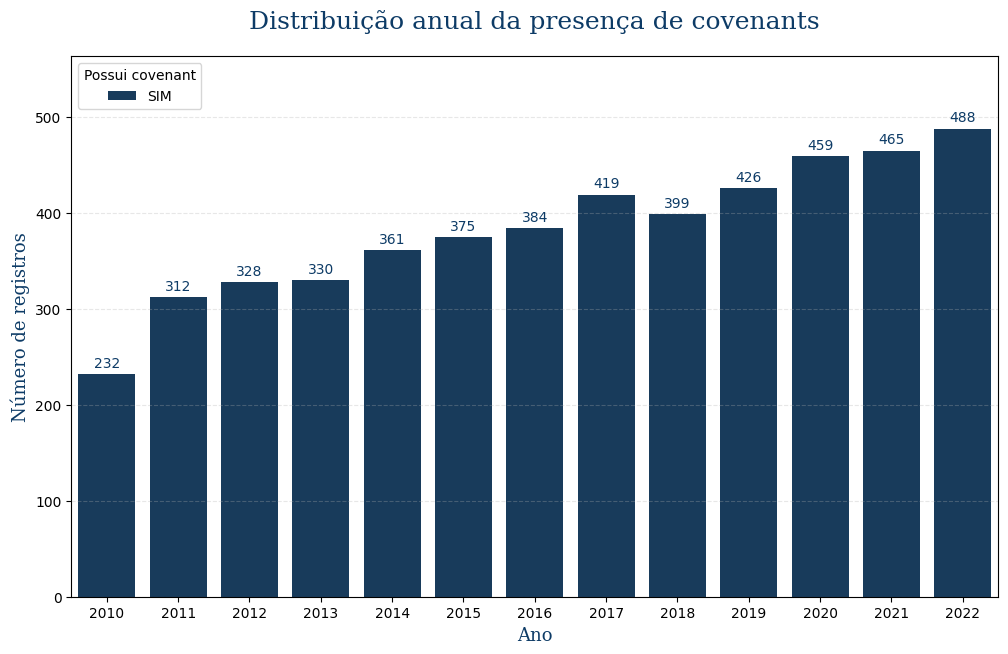

In [282]:
plt.figure(figsize=(10,6))
aplicar_estetica()
ax = sns.countplot(
    data=df_filtrado,
    x="ANO",
    hue="POSSUI COVENANT",
    palette=[azul_escuro, "#d3d3d3"],
    order=sorted(df_filtrado["ANO"].unique())
)

# 2. Loop para adicionar os rótulos em cada barra
for p in ax.patches:
    # p.get_height() é o valor da barra (a contagem)
    # Verificamos se a altura é maior que zero para não rotular barras vazias
    if p.get_height() > 0:
        ax.annotate(
            f'{int(p.get_height())}',                   
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',                               
            va='center',                               
            xytext=(0, 8),                              
            textcoords='offset points',                
            fontsize=10,
            color=azul_escuro
        )

plt.title("Distribuição anual da presença de covenants", fontdict=font_titulo, pad=20)
plt.xlabel("Ano", fontdict=font_eixos)
plt.ylabel("Número de registros", fontdict=font_eixos)
plt.legend(title="Possui covenant", loc="upper left", frameon=True)

plt.ylim(0, ax.get_ylim()[1] * 1.1)
plt.show()

##### 2. Número e proporção de empresas que divulgaram

C:\Users\PPGCC\AppData\Local\Temp\ipykernel_23348\1234702928.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


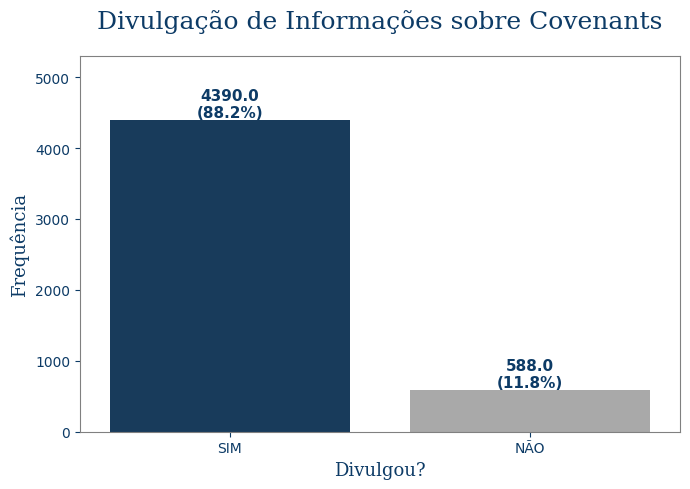

In [283]:
plt.figure(figsize=(7, 5))
ax = sns.countplot(
    data=df_filtrado,
    x="DIVULGOU",
    palette=[azul_escuro, "#a9a9a9"],
    order=df_filtrado["DIVULGOU"].value_counts().index
)
plt.title("Divulgação de Informações sobre Covenants", fontdict=font_titulo, pad=20)
plt.xlabel("Divulgou?", fontdict=font_eixos)
plt.ylabel("Frequência", fontdict=font_eixos)

# Adiciona os rótulos de dados (contagem e porcentagem)
total = len(df_filtrado['DIVULGOU'])
for p in ax.patches:
    count = p.get_height()
    percentage = f'{100 * count / total:.1f}%'
    label = f'{count}\n({percentage})'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(label, (x, y), ha='center', va='bottom', color=azul_escuro, fontweight='bold', size=11)

plt.ylim(0, ax.get_ylim()[1] * 1.15)
plt.tight_layout()
# plt.savefig("proporcao_divulgacao.png")
plt.show()

##### 3. Frequência dos Tipos de Instrumentos

C:\Users\PPGCC\AppData\Local\Temp\ipykernel_23348\2816156062.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


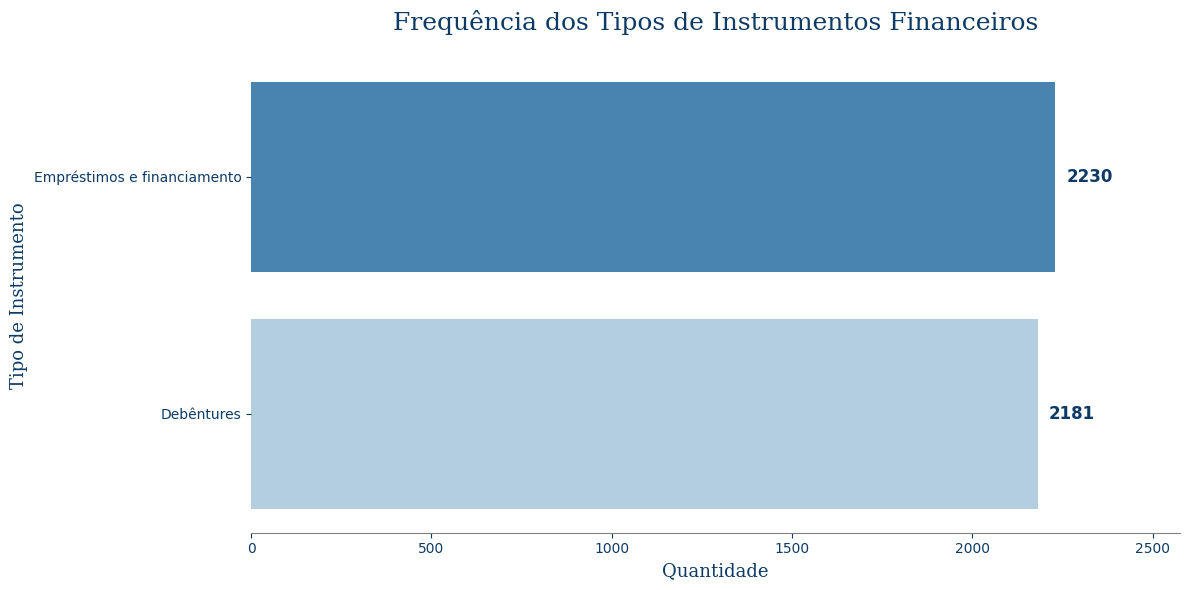

In [284]:
plt.figure(figsize=(12, 6))

ax = sns.countplot(
    data=df_filtrado.dropna(subset=["Debenture ou Empréstimos e financiamento"]),
    y="Debenture ou Empréstimos e financiamento",
    order=df_filtrado["Debenture ou Empréstimos e financiamento"].value_counts().index,
    palette=sns.color_palette("Blues_r", n_colors=df_filtrado["Debenture ou Empréstimos e financiamento"].nunique())
)

for p in ax.patches:
    width = p.get_width() 
    if width > 0:
      ax.annotate(
          f'{int(width)}',
          xy=(width, p.get_y() + p.get_height() / 2), # Posição (x,y) do texto
          xytext=(8, 0), # Deslocamento de 8 pontos para a direita
          textcoords='offset points',
          ha='left', # Alinhamento horizontal
          va='center', # Alinhamento vertical
          fontsize=12,
          color=azul_escuro,
          weight='bold'
          )

# Aumenta o limite do eixo X para dar espaço aos rótulos
plt.xlim(0, ax.get_xlim()[1] * 1.1)

plt.title("Frequência dos Tipos de Instrumentos Financeiros", fontdict=font_titulo, pad=20)
plt.xlabel("Quantidade", fontdict=font_eixos)
plt.ylabel("Tipo de Instrumento", fontdict=font_eixos)

sns.despine(left=True, bottom=False)

plt.tight_layout()
plt.show()

#### 4. Frequência de Cláusulas com Limites Definidos

C:\Users\PPGCC\AppData\Local\Temp\ipykernel_23348\1915347706.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


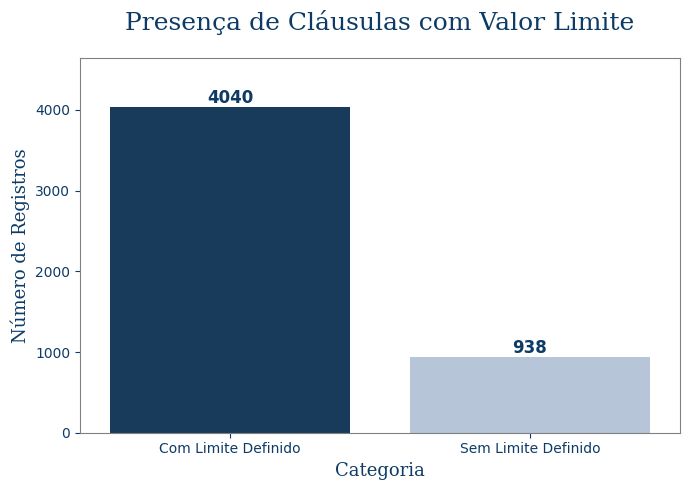

In [285]:
df_filtrado['tem_limite'] = df_filtrado['valor_limite'].notna().map({True: 'Com Limite Definido', False: 'Sem Limite Definido'})
contagem_limites = df_filtrado['tem_limite'].value_counts()

plt.figure(figsize=(7, 5))
ax = sns.barplot(
    x=contagem_limites.index,
    y=contagem_limites.values,
    palette=[azul_escuro, "#b0c4de"]
)
plt.title("Presença de Cláusulas com Valor Limite", fontdict=font_titulo, pad=20)
plt.xlabel("Categoria", fontdict=font_eixos)
plt.ylabel("Número de Registros", fontdict=font_eixos)

# Adiciona os rótulos de dados
for i, v in enumerate(contagem_limites.values):
    ax.text(i, v, str(v), ha='center', va='bottom', color=azul_escuro, fontweight='bold', size=12)

plt.ylim(0, max(contagem_limites.values) * 1.15)
plt.tight_layout()
# plt.savefig("frequencia_clausulas_limite.png")
plt.show()

##### 5. Evolução da Proporção de Covenants ao Longo do Tempo

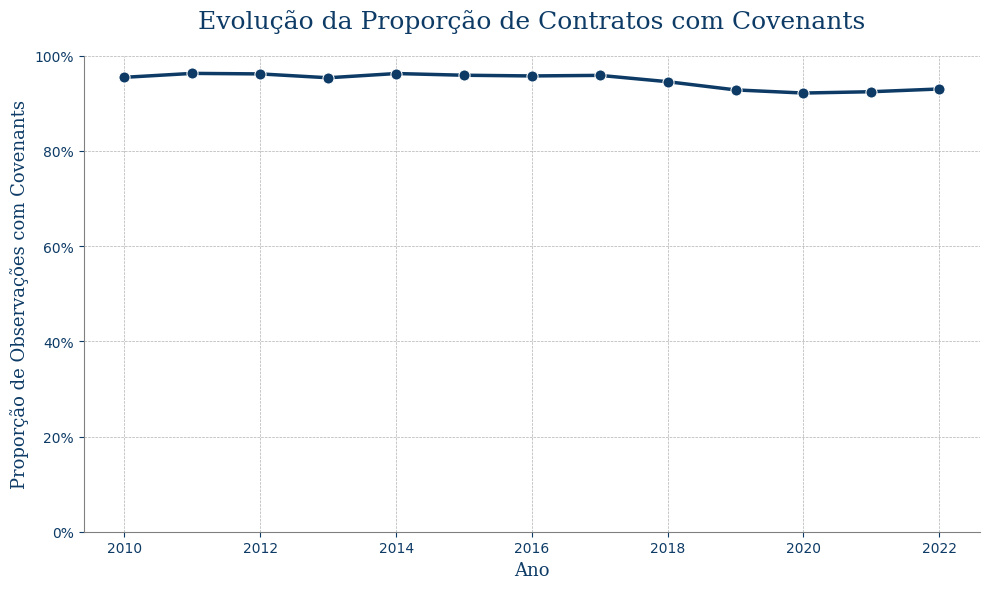

In [286]:
# Calcula a proporção de 'SIM' e 'NÃO' para cada ano
proporcao_ano = df_possui_covenant.groupby('ANO')['POSSUI COVENANT'].value_counts(normalize=True).unstack()

# Plotagem
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=proporcao_ano['SIM'], # Plota apenas a linha para 'SIM'
    marker='o',
    markersize=8,
    linewidth=2.5,
    color=azul_escuro
)

# Formata o eixo Y como porcentagem
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.title('Evolução da Proporção de Contratos com Covenants', fontdict=font_titulo, pad=20)
plt.xlabel('Ano', fontdict=font_eixos)
plt.ylabel('Proporção de Observações com Covenants', fontdict=font_eixos)
plt.ylim(0, 1) # Define o eixo Y de 0% a 100%
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine()
plt.tight_layout()
plt.show()

In [287]:
df_possui_covenant.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5278 entries, 0 to 6259
Data columns (total 13 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Empresa_Setor                             5278 non-null   object 
 1   Setor                                     5278 non-null   object 
 2   ANO                                       5278 non-null   int64  
 3   POSSUI COVENANT                           5271 non-null   object 
 4   DIVULGOU                                  5057 non-null   object 
 5   Debenture ou Empréstimos e financiamento  4415 non-null   object 
 6   Índice Utilizado                          4378 non-null   object 
 7   operador_limite                           4044 non-null   object 
 8   valor_limite                              4044 non-null   float64
 9   Violou?                                   3823 non-null   object 
 10  Limite                                   

## 🏗️ 2. **Análise dos tipos de índices utilizados**

**Objetivo**: entender os indicadores financeiros mais usados como base para os covenants.

Analise:

* Frequência de cada valor em `"Índice Utilizado"` (ex: dívida/EBITDA, cobertura de juros, etc).
* Agrupamento por tipo de índice (liquidez, rentabilidade, endividamento, etc).
* Como esses índices variam por setor.

📌 *Gráficos*: gráfico de barras horizontais com os índices mais comuns.

In [288]:
# Este comando substitui um ou mais caracteres de espaço ('\s+') por nada ('')
# df_filtrado['Índice Utilizado'] = df_filtrado['Índice Utilizado'].str.lower()
# df_filtrado['Índice Utilizado'] = df_filtrado['Índice Utilizado'].str.replace(r'\s+', '', regex=True)
df_filtrado['Índice Utilizado'].nunique()

79

In [289]:
# --- FUNÇÃO AUXILIAR PARA REMOVER ACENTOS ---
def remover_acentos(texto: str) -> str:
    texto_normalizado = unicodedata.normalize('NFD', texto)
    return texto_normalizado.encode('ascii', 'ignore').decode('utf-8')

# --- PIPELINE DE LIMPEZA - VERSÃO FINAL REVISADA ---

def mapear_indice_padrao_revisado(texto_original):
    if not isinstance(texto_original, str):
        return 'N/A'

    # 1. Limpeza Preliminar
    texto = str(texto_original).lower()
    mapa_sinonimos = { 'patrimônio líquido': 'pl', 'patrimonio liquido': 'pl', 'ativo total': 'at', 'ativos': 'at', 'ativo circulante': 'ac', 'passivo circulante': 'pc', 'exigível total': 'exigivel total', 'passivo exigivel': 'exigivel total', 'capital de terceiros': 'exigivel total', 'capital próprio': 'pl', 'dívida líquida': 'divida liquida', 'dívida bruta': 'divida bruta', 'despesas financeiras': 'despesa financeira', 'resultado financeiro': 'resultado financeiro', 'receita operacional líquida': 'receita', 'receita liquida': 'receita', 'ebitida': 'ebitda', 'grau de endividamento': 'endividamento geral', 'icp - índice de capitalização própria': 'icp', 'índice de capitalização própria': 'icp', 'índice de distribuição de resultados': 'distribuicao de dividendos', 'dividendos + jscp / lucro liquido do exercicio': 'distribuicao de dividendos' }
    for k, v in mapa_sinonimos.items(): texto = texto.replace(k, v)
    texto = remover_acentos(texto)
    texto = re.sub(r'[/,;]| sobre | dividido por ', '/', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    
    # 2. Mapeamento Direto (Regras revisadas e novas)
    
    # --- Índices de Cobertura ---
    if re.search(r'ebitda regulatorio\s*/\s*(resultado financeiro|despesa financeira liquida)', texto): return 'EBITDA Regulatório / Resultado Financeiro'
    if re.search(r'ebitda ajustado\s*/\s*despesa financeira', texto): return 'EBITDA Ajustado / Despesa Financeira'
    if re.search(r'ic(s)?d|cobertura d(o|a) servico da divida', texto): return 'ICSD'
    if re.search(r'ebitda\s*/\s*(resultado financeiro|despesa financeira liquida)', texto): return 'EBITDA / Resultado Financeiro'
    if re.search(r'ebit\s*/\s*(despesa|resultado) financeir(o|a)', texto): return 'EBIT / Despesa Financeira'
    if re.search(r'ebitda\s*/\s*(despesa|encargo|custo) financeira', texto): return 'EBITDA / Despesa Financeira'

    # --- Índices de Alavancagem (Endividamento) ---
    if re.search(r'divida liquid(a)?\s*/\s*ebitda\s*ajustado', texto): return 'Dív. Líq. / EBITDA Ajustado'
    if re.search(r'divida liquid(a)?\s*/\s*ebitda', texto): return 'Dív. Líq. / EBITDA'
    if re.search(r'(divida bruta|divida consolidada|divida total)\s*/\s*ebitda', texto): return 'Dív. Bruta / EBITDA'
    if re.search(r'divida (de )?cp liquid(a)?\s*/\s*ebitda', texto): return 'Dív. CP Líq. / EBITDA'
    if re.search(r'divida (de )?cp\s*/\s*ebitda', texto): return 'Dív. CP / EBITDA'
    if re.search(r'divida liquid(a)?\s*/\s*pl', texto): return 'Dív. Líq. / PL'
    if re.search(r'divida brut(a)?\s*/\s*pl', texto): return 'Dív. Bruta / PL'
    if re.search(r'divida liquid(a)?\s*/\s*\(?divida liquid(a)?\s*\+\s*pl\)?', texto): return 'Dív. Líq. / (Dív. Líq. + PL)'
    if re.search(r'divida liquid(a)?\s*/\s*at', texto): return 'Dív. Líq. / Ativo Total'
    if 'alavancagem' in texto: return 'Alavancagem Financeira (Genérico)'

    # --- Índices de Estrutura de Capital (com novas regras da sua lista) ---
    if re.search(r'icp|\bpl\s*/\s*at\b', texto): return 'PL / AT (ICP)'
    if re.search(r'exigivel total\s*/\s*at|endividamento geral', texto): return 'Exigível / Ativo Total (Endividamento Geral)'
    if re.search(r'exigivel total\s*/\s*pl', texto): return 'Exigível Total / PL'
    if re.search(r'pl\s*/\s*passivo total', texto): return 'PL / Passivo Total' #<-- NOVA REGRA ADICIONADA
    if re.search(r'divida (de )?cp\s*/\s*divida total', texto): return 'Dívida CP / Dívida Total' #<-- NOVA REGRA ADICIONADA
    
    # --- Índices de Liquidez ---
    if re.search(r'ac\s*/\s*pc|liquidez corrente', texto): return 'AC / PC (Liquidez Corrente)'
    
    # --- Índices de Rentabilidade ---
    if re.search(r'ebitda\s*/\s*receita|margem ebitda', texto): return 'EBITDA / Receita (Margem EBITDA)'
    
    # --- Cláusulas Não-Financeiras ---
    if 'caixa minimo' in texto: return 'Cláusula: Caixa Mínimo'
    if 'pl minimo' in texto: return 'Cláusula: PL Mínimo'
    if 'restricao de investimento' in texto or 'capex' in texto: return 'Cláusula: Restrição de CAPEX'
    if 'distribuicao de dividendos' in texto: return 'Cláusula: Restrição de Dividendos'

    # --- Por fim, o que for muito específico ou raro ---
    return 'Outros'

# --- APLICAÇÃO DO PIPELINE REVISADO ---
df_filtrado['Indice_Padronizado_Final'] = df_filtrado['Índice Utilizado'].apply(mapear_indice_padrao_revisado)

# --- APRESENTAÇÃO FINAL: TOP 17 + OUTROS (EXCLUINDO N/A) ---
# 1. Filtra os N/A e faz a contagem completa
contagem_completa = df_filtrado[df_filtrado['Indice_Padronizado_Final'] != 'N/A']['Indice_Padronizado_Final'].value_counts()

# 2. Identifica os 17 mais frequentes
top_17 = contagem_completa.nlargest(17)

# 3. Agrupa todo o resto (incluindo a categoria 'Outros' original) em um novo 'Outros'
soma_outros = contagem_completa[~contagem_completa.index.isin(top_17.index)].sum()
outros = pd.Series([soma_outros], index=['Outros'])
contagem_resumo = pd.concat([top_17, outros])

# 4. Criação da tabela final de apresentação
df_resumo = pd.DataFrame(contagem_resumo, columns=['Obs. Freq.'])
df_resumo.index.name = 'Indicador'
total_geral = df_resumo['Obs. Freq.'].sum()
df_resumo['(%)'] = (df_resumo['Obs. Freq.'] / total_geral) * 100
df_resumo_formatado = df_resumo.style.format({'Obs. Freq.': '{:.0f}', '(%)': '{:.1f}%'})

print("--- Tabela Resumo Final: Top 17 Indicadores + Outros ---")
display(df_resumo_formatado)

--- Tabela Resumo Final: Top 17 Indicadores + Outros ---


,Obs. Freq.,(%)
Indicador,,
Dív. Líq. / EBITDA,1831,41.9%
EBITDA / Resultado Financeiro,551,12.6%
ICSD,410,9.4%
EBITDA / Despesa Financeira,326,7.5%
Outros,309,7.1%
Dív. Líq. / PL,211,4.8%
AC / PC (Liquidez Corrente),168,3.8%
Dív. Bruta / EBITDA,91,2.1%
EBITDA / Receita (Margem EBITDA),85,1.9%


In [290]:
nome_arquivo = 'indices_financeiros.txt'
df_filtrado['Indice_Padronizado_Final'].to_csv(nome_arquivo, index=False)
print(f"Arquivo '{nome_arquivo}' foi criado com sucesso.")

Arquivo 'indices_financeiros.txt' foi criado com sucesso.


### Tabela com os índices financeiros padronizados

In [291]:
# --- PASSO 1: PREPARAÇÃO - IDENTIFICAR O TOP 17 E CRIAR A CATEGORIA 'OUTROS' ---

# Filtra os N/A para a análise
df_analise = df_filtrado[df_filtrado['Indice_Padronizado_Final'] != 'N/A'].copy()

# Acha a frequência geral para descobrir o Top 17
contagem_geral = df_analise['Indice_Padronizado_Final'].value_counts()
top_17_indices = contagem_geral.nlargest(17).index

# Cria uma nova coluna onde os índices fora do Top 17 são rotulados como 'Outros'
df_analise['Indice_Para_Tabela'] = np.where(
    df_analise['Indice_Padronizado_Final'].isin(top_17_indices),
    df_analise['Indice_Padronizado_Final'], # Mantém o nome se estiver no Top 17
    'Outros'                               # Rotula como 'Outros' se não estiver
)


# --- GERAÇÃO DA TABELA (SCRIPT ATUALIZADO) ---

# Cria a tabela de frequência usando a nova coluna 'Indice_Para_Tabela'
tabela_frequencia = pd.crosstab(
    df_analise['Indice_Para_Tabela'],
    df_analise['ANO']
)

# Garante que todos os anos no intervalo de seus dados apareçam
if not tabela_frequencia.empty:
    todos_os_anos = range(tabela_frequencia.columns.min(), tabela_frequencia.columns.max() + 1)
    tabela_frequencia = tabela_frequencia.reindex(columns=todos_os_anos, fill_value=0)

# Adiciona a coluna 'Total'
tabela_frequencia['Total'] = tabela_frequencia.sum(axis=1)

# Ordena a tabela pela coluna 'Total' e garante que 'Outros' fique por último
if 'Outros' in tabela_frequencia.index:
    # Separa 'Outros' do resto
    df_sem_outros = tabela_frequencia.drop('Outros')
    df_outros = tabela_frequencia.loc[['Outros']]
    # Ordena o resto
    df_sem_outros_sorted = df_sem_outros.sort_values(by='Total', ascending=False)
    # Junta as partes na ordem correta
    tabela_frequencia = pd.concat([df_sem_outros_sorted, df_outros])
else:
    tabela_frequencia = tabela_frequencia.sort_values(by='Total', ascending=False)


# Calcular e adicionar a coluna 'Freq. (%)'
total_geral_covenants = tabela_frequencia['Total'].sum()
if total_geral_covenants > 0:
    tabela_frequencia['Freq. (%)'] = (tabela_frequencia['Total'] / total_geral_covenants) * 100
else:
    tabela_frequencia['Freq. (%)'] = 0

# Adicionar a linha de 'Total Geral' ao final
soma_colunas = tabela_frequencia.sum()
soma_colunas.name = 'Total Geral'
tabela_frequencia.loc['Total Geral'] = soma_colunas
tabela_frequencia.loc['Total Geral', 'Freq. (%)'] = 100.0 # Garante que o total seja 100%

# --- PASSO 3: FORMATAÇÃO E EXIBIÇÃO ---
tabela_final_formatada = tabela_frequencia.style.format({
    **{ano: '{:.0f}' for ano in todos_os_anos},
    'Total': '{:.0f}',
    'Freq. (%)': '{:.1f}%'
}).bar(subset=['Freq. (%)'], color='#cce5ff', vmin=0)

# Exibe a tabela final formatada
display(tabela_final_formatada)

ANO,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,Total,Freq. (%)
Indice_Para_Tabela,,,,,,,,,,,,,,,
Dív. Líq. / EBITDA,53,87,92,95,117,130,139,148,145,169,199,218,239,1831,41.9%
EBITDA / Resultado Financeiro,27,34,38,39,42,48,48,56,49,42,44,43,41,551,12.6%
ICSD,21,27,31,33,33,29,33,37,32,30,32,34,38,410,9.4%
EBITDA / Despesa Financeira,19,22,23,23,27,28,27,28,28,27,26,24,24,326,7.5%
Dív. Líq. / PL,10,12,15,19,21,17,15,13,13,11,20,23,22,211,4.8%
AC / PC (Liquidez Corrente),13,16,17,15,14,13,14,14,12,10,9,11,10,168,3.8%
Dív. Bruta / EBITDA,6,12,6,7,7,8,6,8,9,7,6,5,4,91,2.1%
EBITDA / Receita (Margem EBITDA),9,12,14,10,8,7,6,5,5,3,3,3,0,85,1.9%
Dív. Líq. / EBITDA Ajustado,1,2,2,2,2,2,2,4,6,16,9,9,16,73,1.7%


In [292]:
# Renomeia o índice para aparecer como um cabeçalho de coluna na imagem
tabela_frequencia.index.name = 'Indicador'
tabela_frequencia.reset_index(inplace=True)


# --- PASSO 2: ESTILIZAÇÃO AVANÇADA PARA O ARTIGO ---
# Converte colunas de anos para inteiro para remover o '.0'
for ano in todos_os_anos:
    tabela_frequencia[ano] = tabela_frequencia[ano].astype(int)
tabela_frequencia['Total'] = tabela_frequencia['Total'].astype(int)


tabela_final_estilizada = (tabela_frequencia.style
    .format({
        'Freq. (%)': '{:.1f}%'
    })
    .hide(axis='index') # Esconde o índice numérico da tabela
    .set_caption("Tabela 1: Frequência de Covenants Financeiros por Ano")
    .set_table_styles([
        {'selector': 'caption', 'props': [('color', '#0d3b66'), ('font-size', '18px'), ('font-weight', 'bold'), ('font-family', 'serif')]},
        {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('font-family', 'serif')]},
        {'selector': 'tr:last-child', 'props': [('font-weight', 'bold'), ('border-top', '2px solid black')]}
    ])
    .bar(subset=['Freq. (%)'], color='#cce5ff', vmin=0, align='zero')
)

# --- PASSO 3: SALVAR A TABELA ESTILIZADA COMO IMAGEM ---
nome_arquivo_imagem = 'tabela_frequencia_covenants.png'
dfi.export(tabela_final_estilizada, nome_arquivo_imagem, dpi=300)

print(f"Tabela salva com sucesso como uma imagem no arquivo: '{nome_arquivo_imagem}'")

# Exibe a tabela no notebook para conferência
display(tabela_final_estilizada)

Error: It looks like you are using Playwright Sync API inside the asyncio loop.
Please use the Async API instead.

##### Análise Proporcional de Tipos de Covenant por Setor (Heatmap)

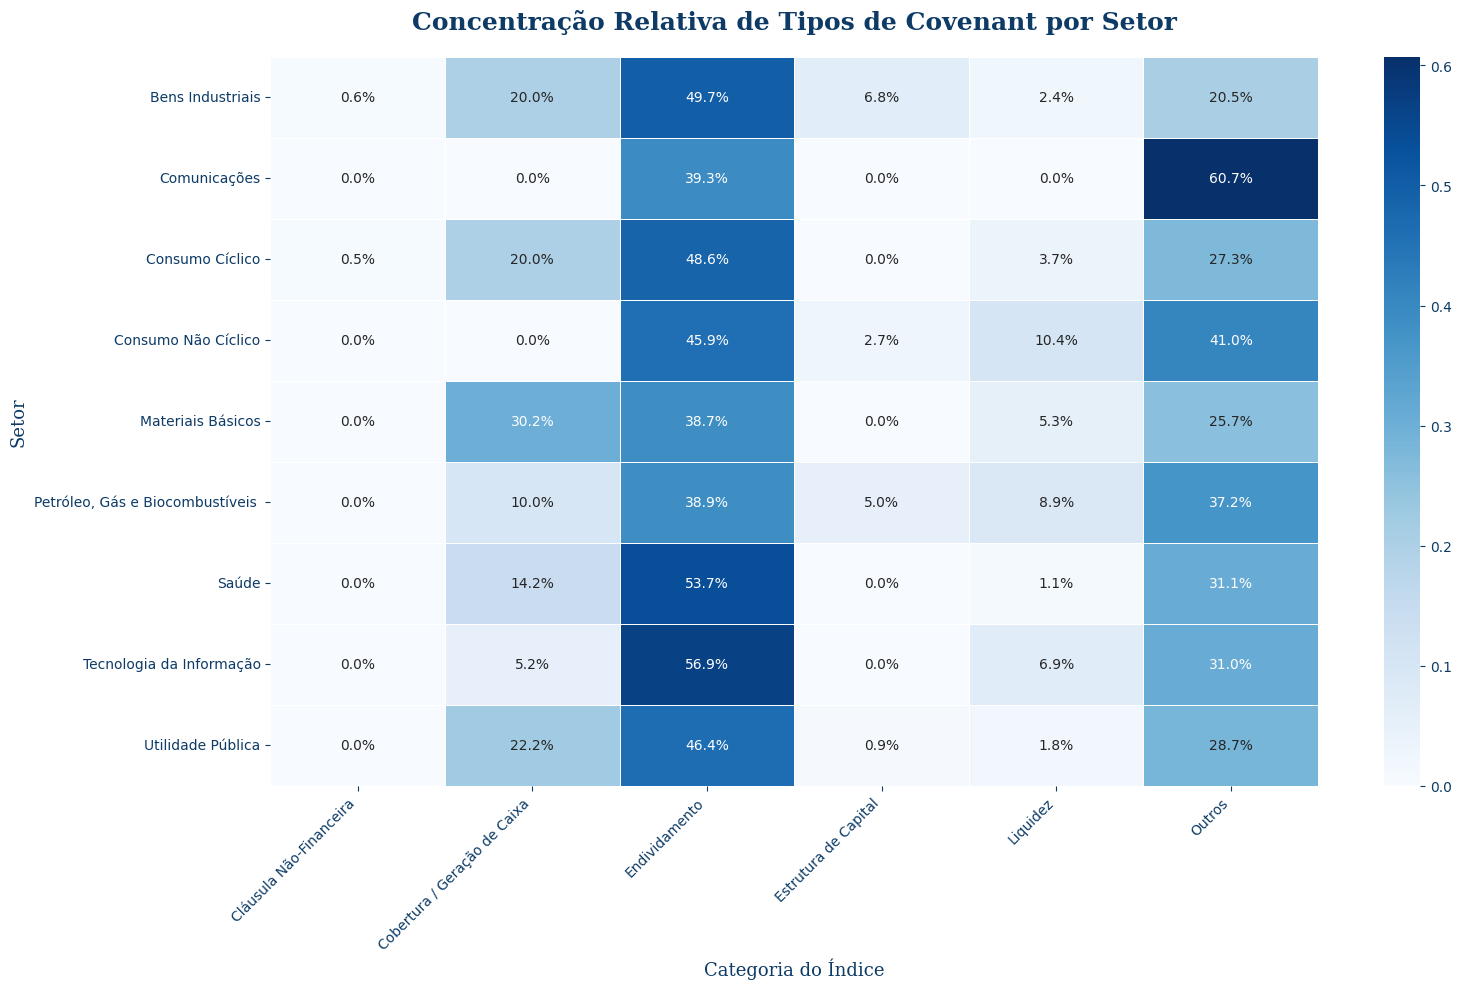

In [293]:
# --- ESTÉTICA DO GRÁFICO ---
azul_escuro = "#0d3b66"
font_titulo = {'family': 'serif', 'color': azul_escuro, 'size': 18, 'weight': 'bold'}
font_eixos = {'family': 'serif', 'color': azul_escuro, 'size': 13}
# --- FIM DA ESTÉTICA ---


# 1. Criar a coluna de Categoria do Índice
def categorizar_indice(indice_padronizado):
    if not isinstance(indice_padronizado, str): return 'N/A'
    if 'dív' in indice_padronizado.lower() or 'alavancagem' in indice_padronizado.lower() or 'endividamento' in indice_padronizado.lower():
        return 'Endividamento'
    if 'ebitda /' in indice_padronizado.lower() or 'ebit /' in indice_padronizado.lower() or 'icds' in indice_padronizado.lower():
        return 'Cobertura / Geração de Caixa'
    if 'liquidez' in indice_padronizado.lower():
        return 'Liquidez'
    if 'pl /' in indice_padronizado.lower() or 'exigível /' in indice_padronizado.lower():
        return 'Estrutura de Capital'
    if 'cláusula' in indice_padronizado.lower():
        return 'Cláusula Não-Financeira'
    return 'Outros'

df_filtrado['Categoria_Indice'] = df_filtrado['Indice_Padronizado_Final'].apply(categorizar_indice)

# 2. Criar a tabela de contingência e normalizá-la por setor (por linha)
tabela_setor_categoria = pd.crosstab(
    df_filtrado['Setor'],
    df_filtrado['Categoria_Indice'],
    normalize='index' # <--- A MÁGICA ACONTECE AQUI
)

# 3. Plotagem do Mapa de Calor
plt.figure(figsize=(16, 10))
sns.heatmap(
    tabela_setor_categoria,
    annot=True,
    fmt='.1%', # Formata as anotações como porcentagem
    cmap='Blues',
    linewidths=.5,
    linecolor='white'
)

plt.title('Concentração Relativa de Tipos de Covenant por Setor', fontdict=font_titulo, pad=20)
plt.xlabel('Categoria do Índice', fontdict=font_eixos)
plt.ylabel('Setor', fontdict=font_eixos)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##### A Evolução dos Tipos de Covenant ao Longo do Tempo

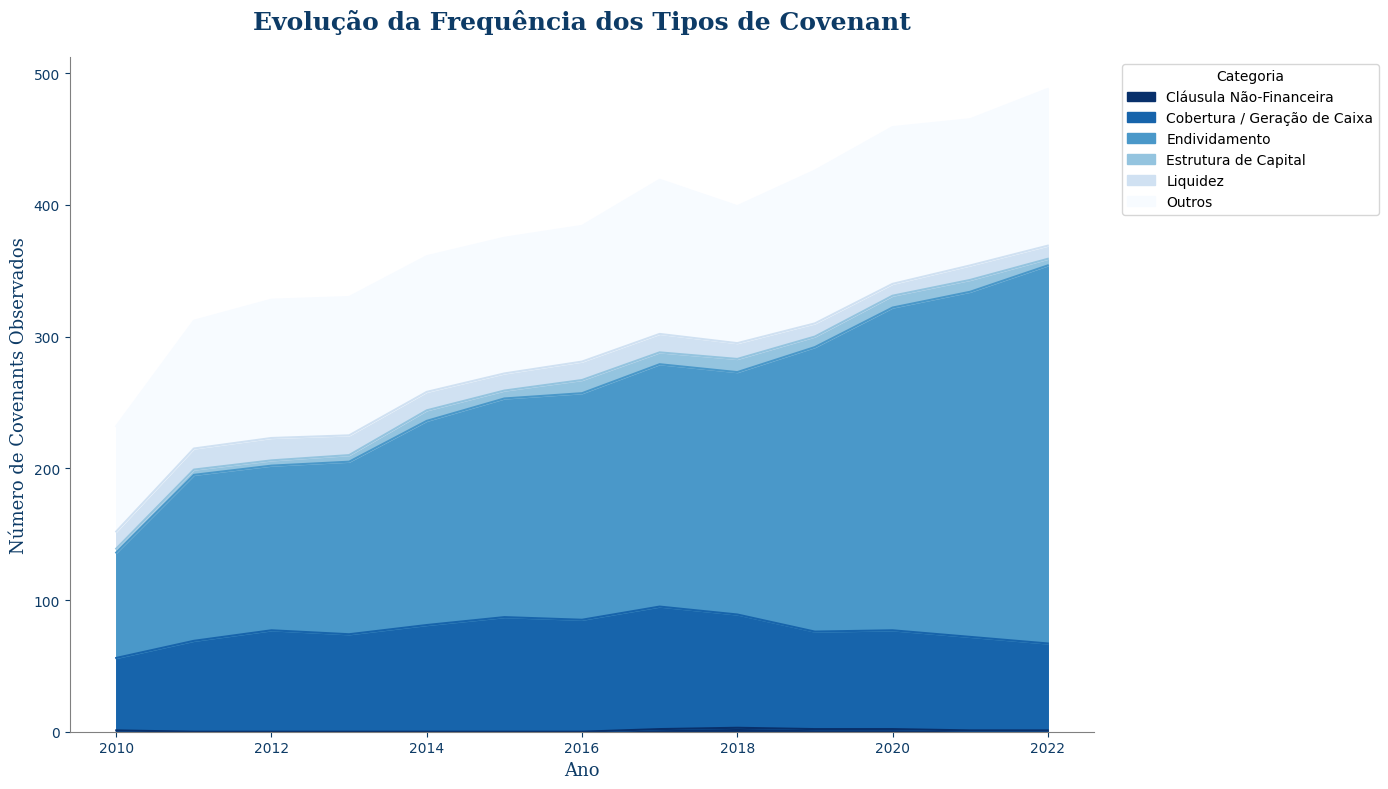

In [294]:
# 1. Criar a tabela de contingência e normalizá-la por ano (por coluna)
tabela_ano_categoria = pd.crosstab(
    df_filtrado['ANO'],
    df_filtrado['Categoria_Indice']
).T # Transpõe para facilitar a plotagem

# 2. Plotagem do Gráfico de Área Empilhada
ax = tabela_ano_categoria.T.plot(
    kind='area',
    stacked=True,
    figsize=(14, 8),
    colormap='Blues_r'
)

plt.title('Evolução da Frequência dos Tipos de Covenant', fontdict=font_titulo, pad=20)
plt.xlabel('Ano', fontdict=font_eixos)
plt.ylabel('Número de Covenants Observados', fontdict=font_eixos)
plt.legend(title='Categoria', bbox_to_anchor=(1.02, 1), loc='upper left')
sns.despine()
plt.tight_layout()
plt.show()

Resumo das Categorias de Covenants e Referências Acadêmicas
1. Endividamento (Leverage)
Resumo: Esta é a categoria mais comum e importante. Os covenants de endividamento estabelecem um teto para o nível de alavancagem de uma empresa. O objetivo do credor é impedir que a empresa assuma um volume de dívidas que comprometa sua capacidade de pagamento futuro. Eles geralmente comparam um estoque de dívida com uma medida de geração de caixa ou com o capital próprio.

Exemplos: Dívida Líquida / EBITDA, Dívida Bruta / EBITDA, Dívida Líquida / PL.

Uso em Artigos: A análise de covenants de endividamento é um pilar na literatura de finanças corporativas, fundamentada pela teoria de agência (Jensen e Meckling, 1976). As tabelas que você compartilhou (de Albanez e do outro artigo) demonstram que esta é, de longe, a categoria mais frequente de covenants no mercado brasileiro. Estudos como os de Smith e Warner (1979) já identificavam essas cláusulas como essenciais para mitigar conflitos entre acionistas e credores.

2. Cobertura / Geração de Caixa (Coverage / Cash Flow)
Resumo: Covenants de cobertura medem a capacidade da geração de caixa da empresa de "cobrir" suas despesas financeiras ou o serviço da dívida. Enquanto os índices de endividamento olham para o "estoque" da dívida, os de cobertura focam no "fluxo" de pagamento. O objetivo do credor é garantir que a operação da empresa gere caixa suficiente para pagar os juros e o principal no curto prazo.

Exemplos: EBITDA / Despesa Financeira, EBITDA / Resultado Financeiro, ICSD (Índice de Cobertura do Serviço da Dívida).

Uso em Artigos: Artigos frequentemente analisam a popularidade dos covenants de cobertura em relação aos de endividamento. Pesquisas mais recentes, como as de Christensen e Nikolaev (2012), discutem a mudança de foco dos credores de covenants baseados no balanço (como os de capital) para covenants baseados no desempenho e na geração de caixa (como os de cobertura), pois são mais sensíveis a quedas na performance operacional. As tabelas que você possui mostram que os índices de cobertura são o segundo grupo mais relevante no Brasil.

3. Liquidez (Liquidity)
Resumo: Esta categoria de covenant foca na capacidade da empresa de honrar suas obrigações de curto prazo. O objetivo do credor é garantir que a empresa mantenha um nível mínimo de capital de giro para não enfrentar problemas de caixa imediatos que poderiam levar à inadimplência.

Exemplos: AC / PC (Liquidez Corrente).

Uso em Artigos: Covenants de liquidez são considerados mais tradicionais e são frequentemente analisados em conjunto com os de endividamento. Em alguns estudos, a sua utilização é associada a empresas com maior risco de curto prazo ou em setores com grande necessidade de capital de giro. A sua presença nas tabelas de referência, embora com menor frequência que os de endividamento e cobertura, confirma sua contínua relevância.

4. Estrutura de Capital (Capital Structure)
Resumo: Estes covenants definem regras sobre a composição do financiamento da empresa, ou seja, a proporção entre o capital dos sócios (Patrimônio Líquido) e o capital de terceiros (dívidas). O objetivo do credor é garantir que os acionistas mantenham um nível mínimo de "pele em risco", evitando que a empresa seja financiada quase que exclusivamente por dívidas.

Exemplos: PL / Ativo Total (ICP), Exigível / Ativo Total (Endividamento Geral), Exigível Total / PL.

Uso em Artigos: A análise da estrutura de capital é um tema clássico em finanças (Modigliani e Miller, 1958), e os covenants dessa natureza são vistos como uma forma contratual de reforçar uma estrutura considerada ótima ou segura. Os artigos que você compartilhou destacam a importância de índices como PL / AT, mostrando que os credores se preocupam não apenas com a relação dívida/caixa, mas também com a base de capital que suporta toda a operação.

5. Cláusula Não-Financeira (Non-Financial Clause)
Resumo: Diferente dos outros, este grupo não se baseia em um índice, mas em restrições a ações específicas da gestão. São promessas de "fazer" ou "não fazer" algo. O objetivo do credor é controlar decisões estratégicas que poderiam aumentar o risco da empresa.

Exemplos: Cláusula: Restrição de CAPEX, Cláusula: PL Mínimo, Cláusula: Restrição de Dividendos.

Uso em Artigos: A literatura divide os covenants em "financeiros" (baseados em números) e "não-financeiros" (ou gerais). Trabalhos clássicos como o de Smith e Warner (1979) já detalhavam a importância de cláusulas que restringem fusões, aquisições, venda de ativos e, principalmente, o pagamento de dividendos, que é visto como uma forma de transferir riqueza dos credores para os acionistas. A análise dessas cláusulas geralmente é feita de forma qualitativa ou através de contagem de sua incidência.

##### Gráfico de Sol (Sunburst) - A Hierarquia dos Covenants

`Como Interpretar: O círculo central representa o total. O primeiro anel são os Setores. Ao clicar em um setor, você verá ele se expandir para o próximo anel, as Categorias de Índice. Clicando em uma categoria, você verá os índices específicos. É uma ferramenta de exploração visual fantástica.`

In [ ]:
import plotly.express as px

# 1. Preparar os dados para a plotagem (contar as ocorrências)
df_sunburst = df_filtrado.groupby(['Setor', 'Categoria_Indice', 'Indice_Padronizado_Final']).size().reset_index(name='contagem')

# 2. Criar o gráfico de sol interativo
fig = px.sunburst(
    df_sunburst,
    path=['Setor', 'Categoria_Indice', 'Indice_Padronizado_Final'], # Define a hierarquia
    values='contagem',
    color='Setor',
    color_discrete_map={'(?)':'#0d3b66', 'Bens Industriais':'#2a9d8f', 'Consumo Cíclico':'#e9c46a', 
                        'Utilidade Pública':'#f4a269', 'Outros':'#e76f51'} # Cores personalizadas
)

fig.update_layout(
    title_text='Hierarquia e Concentração de Covenants por Setor e Categoria',
    title_font_family="serif",
    title_font_color=azul_escuro,
    title_font_size=22,
    margin = dict(t=90, l=0, r=0, b=10)
)

fig.show()

ModuleNotFoundError: No module named 'plotly'

###  *Analisando os tipos de covenant: debênture vs. empréstimo*

C:\Users\PPGCC\AppData\Local\Temp\ipykernel_23348\2435421937.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_6_debentures.values, y=top_6_debentures.index, palette='Blues_r', ax=ax1)
C:\Users\PPGCC\AppData\Local\Temp\ipykernel_23348\2435421937.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_6_emprestimos.values, y=top_6_emprestimos.index, palette='Blues_r', ax=ax2)


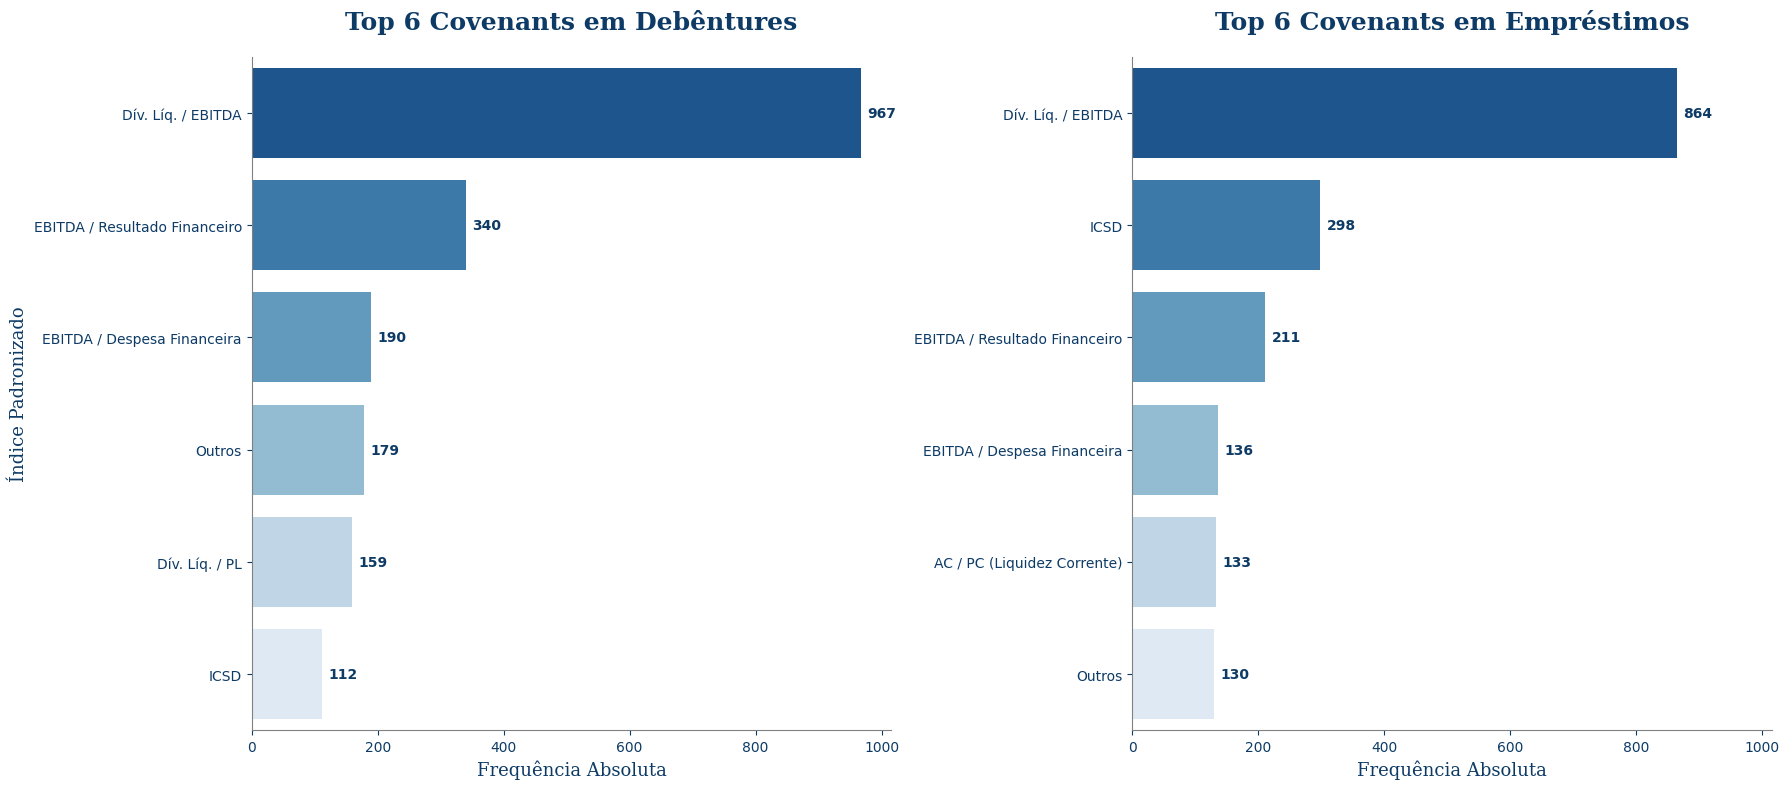

In [ ]:
# 1. Preparar os dados
df_analise = df_filtrado.dropna(subset=['Debenture ou Empréstimos e financiamento', 'Indice_Padronizado_Final'])
df_debentures = df_analise[df_analise['Debenture ou Empréstimos e financiamento'] == 'Debêntures']
df_emprestimos = df_analise[df_analise['Debenture ou Empréstimos e financiamento'] == 'Empréstimos e financiamento']

top_6_debentures = df_debentures['Indice_Padronizado_Final'].value_counts().nlargest(6)
top_6_emprestimos = df_emprestimos['Indice_Padronizado_Final'].value_counts().nlargest(6)

# 2. Plotagem em facetas (dois gráficos lado a lado)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 8), sharex=True)

# Gráfico para Debêntures
sns.barplot(x=top_6_debentures.values, y=top_6_debentures.index, palette='Blues_r', ax=ax1)
ax1.set_title('Top 6 Covenants em Debêntures', fontdict=font_titulo, pad=20)
ax1.set_xlabel('Frequência Absoluta', fontdict=font_eixos)
ax1.set_ylabel('Índice Padronizado', fontdict=font_eixos)

# Gráfico para Empréstimos e Financiamentos
sns.barplot(x=top_6_emprestimos.values, y=top_6_emprestimos.index, palette='Blues_r', ax=ax2)
ax2.set_title('Top 6 Covenants em Empréstimos', fontdict=font_titulo, pad=20)
ax2.set_xlabel('Frequência Absoluta', fontdict=font_eixos)
ax2.set_ylabel('') # Remove o label Y para não poluir

# Adicionar rótulos de dados
for ax in [ax1, ax2]:
    for p in ax.patches:
        ax.text(p.get_width() + (ax.get_xlim()[1] * 0.01), p.get_y() + p.get_height() / 2,
                f'{int(p.get_width())}', va='center', ha='left', color=azul_escuro, fontweight='bold')

sns.despine()
plt.tight_layout()
plt.show()

#### Rigidez comparativa: Qual limite é mais "apertado"?

Covenants em Empréstimos são mais Rígidos e Numerosos: Bancos, por terem uma relação mais próxima e custos de renegociação mais baixos, tendem a impor cláusulas mais "apertadas" e em maior quantidade. Eles atuam como monitores ativos. Em contrapartida, os contratos de debêntures (dívida pública) são mais padronizados e menos restritivos, pois a renegociação com centenas de credores é muito mais custosa e complexa

In [ ]:
# 1. Selecionar os principais índices para a comparação
indices_para_comparar = [
    'Dív. Líq. / EBITDA', 
    'ICSD', 
    'EBITDA / Resultado Financeiro',
    'EBITDA / Despesa Financeira',
    'AC / PC (Liquidez Corrente)',
    'Dív. Líq. / PL'  # Adicionando mais um para robustez
]
df_analise_multipla = df_filtrado[
    df_filtrado['Indice_Padronizado_Final'].isin(indices_para_comparar) &
    df_filtrado['valor_limite'].notna()
]

# 2. Gerar a tabela de estatísticas descritivas agrupada
tabela_multipla = df_analise_multipla.groupby(
    ['Indice_Padronizado_Final', 'Debenture ou Empréstimos e financiamento']
)['valor_limite'].describe().round(2)

# Exibir a tabela
print("--- Tabela Comparativa de Rigidez para Múltiplos Covenants ---")
display(tabela_multipla)

--- Tabela Comparativa de Rigidez para Múltiplos Covenants ---


count  \
Indice_Padronizado_Final      Debenture ou Empréstimos e financiamento          
AC / PC (Liquidez Corrente)   Debêntures                                 34.0   
                              Empréstimos e financiamento               109.0   
Dív. Líq. / EBITDA            Debêntures                                922.0   
                              Empréstimos e financiamento               751.0   
Dív. Líq. / PL                Debêntures                                154.0   
                              Empréstimos e financiamento                45.0   
EBITDA / Despesa Financeira   Debêntures                                190.0   
                              Empréstimos e financiamento               136.0   
EBITDA / Resultado Financeiro Debêntures                                319.0   
                              Empréstimos e financiamento               190.0   
ICSD                          Debêntures                                109.0   
                              Empréstimos e financiamento               259.0   

                                                                        mean  \
Indice_Padronizado_Final      Debenture ou Empréstimos e financiamento         
AC / PC (Liquidez Corrente)   Debêntures                                1.12   
                              Empréstimos e financiamento               1.08   
Dív. Líq. / EBITDA            Debêntures                                3.43   
                              Empréstimos e financiamento               3.61   
Dív. Líq. / PL                Debêntures                                1.10   
                              Empréstimos e financiamento               1.34   
EBITDA / Despesa Financeira   Debêntures                                1.91   
                              Empréstimos e financiamento               2.08   
EBITDA / Resultado Financeiro Debêntures                                2.02   
                              Empréstimos e financiamento               1.53   
ICSD                          Debêntures                                1.32   
                              Empréstimos e financiamento               1.30   

                                                                         std  \
Indice_Padronizado_Final      Debenture ou Empréstimos e financiamento         
AC / PC (Liquidez Corrente)   Debêntures                                0.12   
                              Empréstimos e financiamento               0.22   
Dív. Líq. / EBITDA            Debêntures                                0.87   
                              Empréstimos e financiamento               2.70   
Dív. Líq. / PL                Debêntures                                0.83   
                              Empréstimos e financiamento               1.03   
EBITDA / Despesa Financeira   Debêntures                                0.51   
                              Empréstimos e financiamento               0.67   
EBITDA / Resultado Financeiro Debêntures                                0.63   
                              Empréstimos e financiamento               0.94   
ICSD                          Debêntures                                0.23   
                              Empréstimos e financiamento               0.19   

                                                                         min  \
Indice_Padronizado_Final      Debenture ou Empréstimos e financiamento         
AC / PC (Liquidez Corrente)   Debêntures                                1.00   
                              Empréstimos e financiamento               0.60   
Dív. Líq. / EBITDA            Debêntures                                1.00   
                              Empréstimos e financiamento               0.20   
Dív. Líq. / PL                Debêntures                                0.45   
                              Empréstimos e financiamento               0.67   
EBITDA / Despesa Financeira   Debêntures               

#### Contagem Média de Covenants por contrato

C:\Users\PPGCC\AppData\Local\Temp\ipykernel_23348\2306191140.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


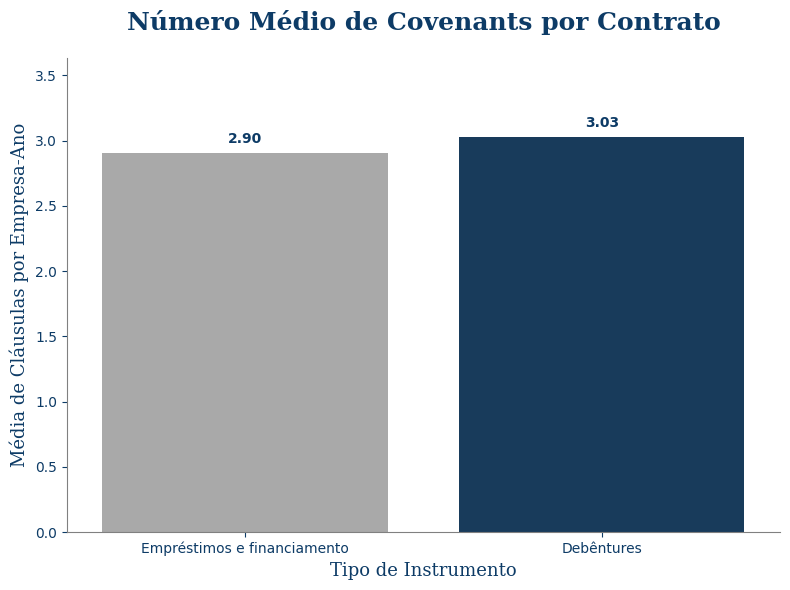

In [ ]:
# 1. Calcular o número de covenants por empresa-ano para cada instrumento
contagem_por_contrato = df_filtrado.groupby(
    ['EMPRESA', 'ANO', 'Debenture ou Empréstimos e financiamento']
).size().reset_index(name='num_covenants')

# 2. Calcular a média de covenants por tipo de instrumento
media_covenants = contagem_por_contrato.groupby('Debenture ou Empréstimos e financiamento')['num_covenants'].mean().sort_values()

# 3. Plotagem do Gráfico de Barras
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    x=media_covenants.index,
    y=media_covenants.values,
    palette=[cinza_claro, azul_escuro]
)

# Adiciona os rótulos de dados
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points',
                fontweight='bold', color=azul_escuro)

plt.title('Número Médio de Covenants por Contrato', fontdict=font_titulo, pad=20)
plt.xlabel('Tipo de Instrumento', fontdict=font_eixos)
plt.ylabel('Média de Cláusulas por Empresa-Ano', fontdict=font_eixos)
plt.ylim(0, media_covenants.max() * 1.2)
sns.despine()
plt.tight_layout()
plt.show()

#### Evolução Temporal da Rigidez: Uma Visão Dinâmica
Motivo do Gráfico: Este gráfico combina as duas análises, mostrando se a rigidez dos contratos de debêntures e empréstimos evoluiu de forma diferente ao longo do tempo, talvez em resposta a crises ou mudanças na política monetária.

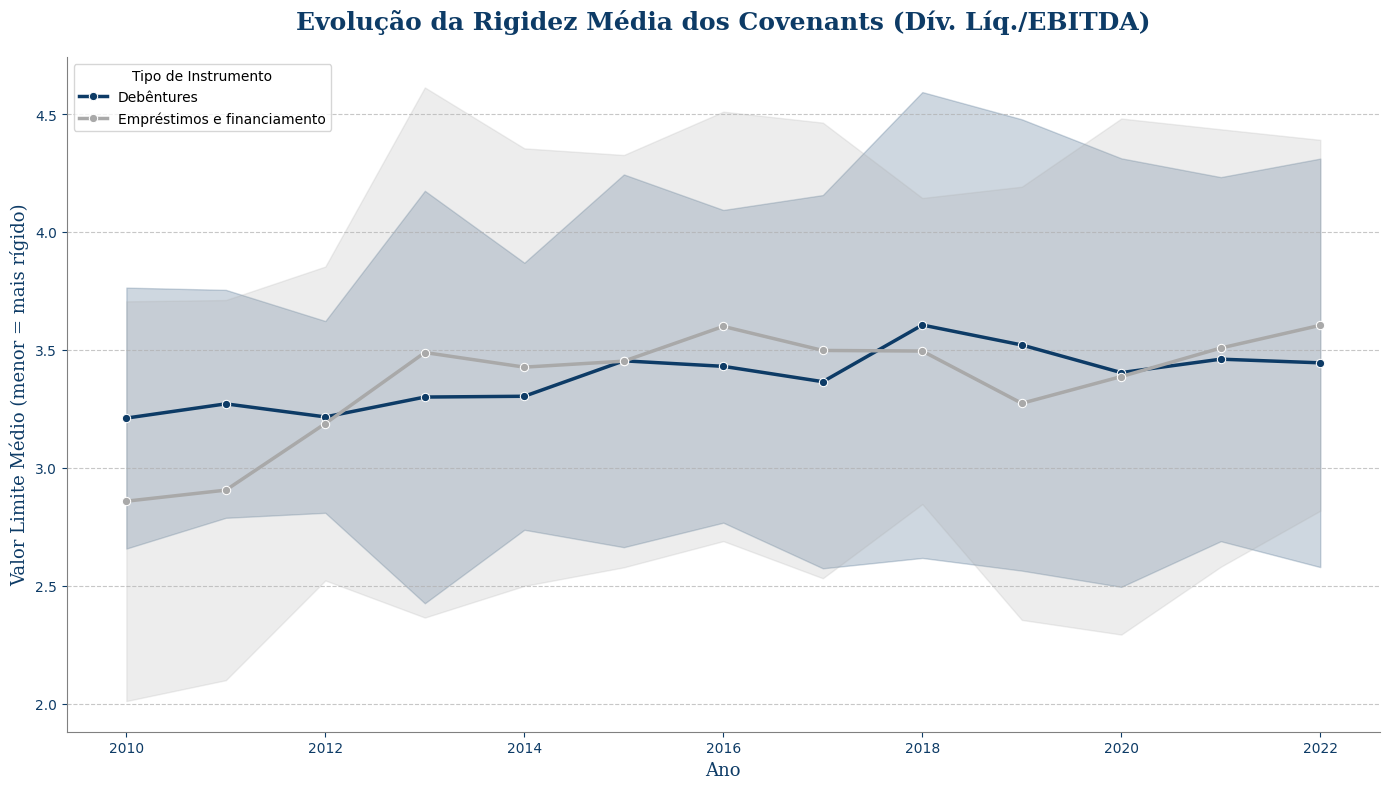

In [ ]:
# 1. Preparar os dados
df_limites = df_filtrado[
    (df_filtrado['Indice_Padronizado_Final'] == 'Dív. Líq. / EBITDA') &
    (df_filtrado['valor_limite'].notna()) &
    (df_filtrado['valor_limite'] < 10)
].copy()

# 2. Plotagem do Gráfico de Linha com Intervalo de Confiança
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=df_limites,
    x='ANO',
    y='valor_limite',
    hue='Debenture ou Empréstimos e financiamento',
    marker='o',
    linewidth=2.5,
    palette={'Debêntures': azul_escuro, 'Empréstimos e financiamento': cinza_claro},
    errorbar='sd'
)

plt.title('Evolução da Rigidez Média dos Covenants (Dív. Líq./EBITDA)', fontdict=font_titulo, pad=20)
plt.xlabel('Ano', fontdict=font_eixos)
plt.ylabel('Valor Limite Médio (menor = mais rígido)', fontdict=font_eixos)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Tipo de Instrumento')
sns.despine()
plt.tight_layout()
plt.show()

####  Setores com Mais Violações: Debêntures vs. Empréstimos

C:\Users\PPGCC\AppData\Local\Temp\ipykernel_23348\3082523749.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_analise['Violou_num'] = df_analise['Violou?'].replace({'SIM': 1, 'NÃO': 0})
C:\Users\PPGCC\AppData\Local\Temp\ipykernel_23348\3082523749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analise['Violou_num'] = df_analise['Violou?'].replace({'SIM': 1, 'NÃO': 0})
C:\Users\PPGCC\AppData\Local\Temp\ipykernel_23348\3082523749.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated

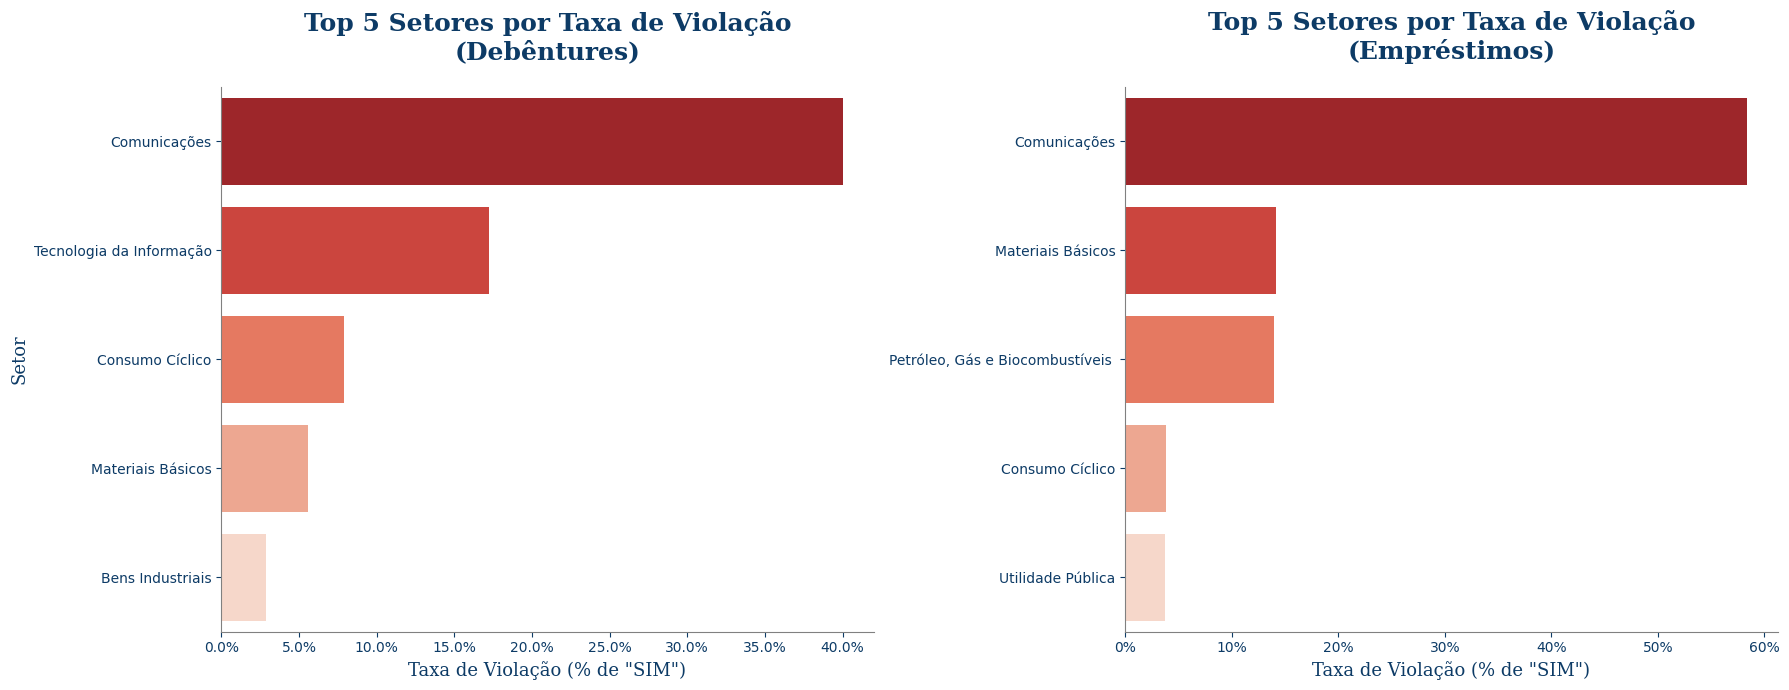

In [ ]:
df_analise = df_filtrado.dropna(subset=['Debenture ou Empréstimos e financiamento', 'Setor', 'Violou?'])
df_analise['Violou_num'] = df_analise['Violou?'].replace({'SIM': 1, 'NÃO': 0})

df_debentures = df_analise[df_analise['Debenture ou Empréstimos e financiamento'] == 'Debêntures']
df_emprestimos = df_analise[df_analise['Debenture ou Empréstimos e financiamento'] == 'Empréstimos e financiamento']

taxa_viol_debentures = df_debentures.groupby('Setor')['Violou_num'].mean().nlargest(5) * 100
taxa_viol_emprestimos = df_emprestimos.groupby('Setor')['Violou_num'].mean().nlargest(5) * 100

# 2. Plotagem em facetas
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# Gráfico para Debêntures
sns.barplot(x=taxa_viol_debentures.values, y=taxa_viol_debentures.index, palette='Reds_r', ax=ax1)
ax1.set_title('Top 5 Setores por Taxa de Violação\n(Debêntures)', fontdict=font_titulo, pad=20)
ax1.set_xlabel('Taxa de Violação (% de "SIM")', fontdict=font_eixos)
ax1.set_ylabel('Setor', fontdict=font_eixos)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter())

# Gráfico para Empréstimos
sns.barplot(x=taxa_viol_emprestimos.values, y=taxa_viol_emprestimos.index, palette='Reds_r', ax=ax2)
ax2.set_title('Top 5 Setores por Taxa de Violação\n(Empréstimos)', fontdict=font_titulo, pad=20)
ax2.set_xlabel('Taxa de Violação (% de "SIM")', fontdict=font_eixos)
ax2.set_ylabel('')
ax2.xaxis.set_major_formatter(mtick.PercentFormatter())

sns.despine()
plt.tight_layout()
plt.show()


## 📊 3. **Distribuição dos limites numéricos**

**Objetivo**: avaliar os **valores definidos nos contratos** como critérios para quebra de covenant.

* Distribuição dos valores numéricos extraídos (`valor_limite`) por índice.
* Diferença nos limites definidos por setor.
* Comparar limites para empresas que **violaram** e **não violaram**.

📌 *Gráficos*: boxplots por índice, por setor, por status de violação.

#### 1. Tabela de Resumo dos Limites por Tipo de Índice

C:\Users\Maria Eduarda\AppData\Local\Temp\ipykernel_8564\882269978.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




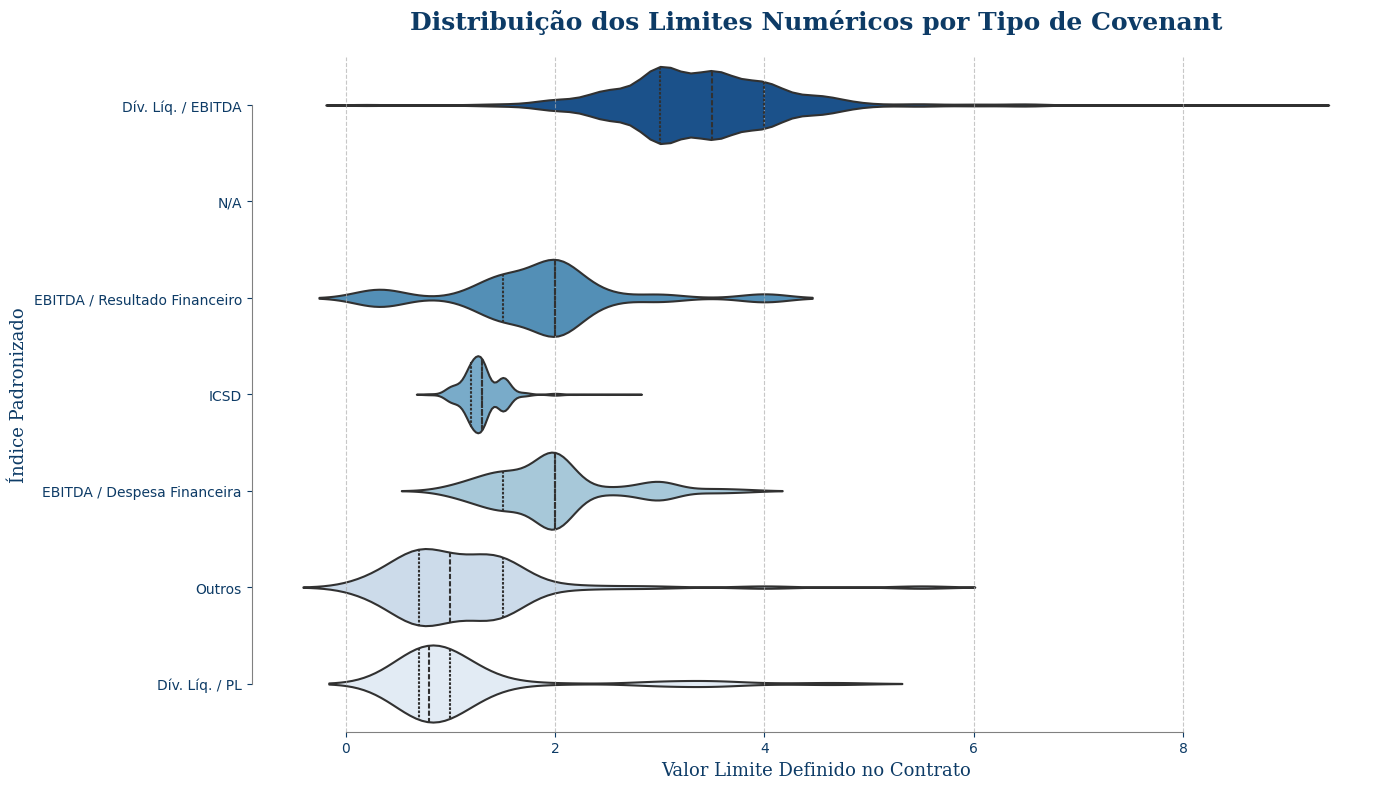

In [ ]:
# 1. Preparar os dados: selecionar os 6 índices mais comuns e remover outliers
top_7_indices = df_filtrado['Indice_Padronizado_Final'].value_counts().nlargest(7).index
df_limites_por_indice = df_filtrado[
    df_filtrado['Indice_Padronizado_Final'].isin(top_7_indices) &
    df_filtrado['valor_limite'].notna() &
    (df_filtrado['valor_limite'] > 0) & # Remove limites negativos ou zero
    (df_filtrado['valor_limite'] < 10) # Remove outliers extremos para melhor visualização
].copy()

# 2. Plotagem do Gráfico de Violino
plt.figure(figsize=(14, 8))
sns.violinplot(
    data=df_limites_por_indice,
    x='valor_limite',
    y='Indice_Padronizado_Final',
    order=top_7_indices,
    palette='Blues_r',
    inner='quart', # Mostra os quartis dentro do violino
    linewidth=1.5
)

plt.title('Distribuição dos Limites Numéricos por Tipo de Covenant', fontdict=font_titulo, pad=20)
plt.xlabel('Valor Limite Definido no Contrato', fontdict=font_eixos)
plt.ylabel('Índice Padronizado', fontdict=font_eixos)
plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(trim=True)
plt.tight_layout()
plt.show()

In [ ]:
# 1. Preparar os dados: selecionar os 6 índices mais comuns e remover outliers
top_10_indices = df_filtrado['Indice_Padronizado_Final'].value_counts().nlargest(10).index
df_limites_por_indice = df_filtrado[
    df_filtrado['Indice_Padronizado_Final'].isin(top_10_indices) &
    df_filtrado['valor_limite'].notna() &
    (df_filtrado['valor_limite'] > 0) & 
    (df_filtrado['valor_limite'] < 10)
].copy()

# 2. Gerar a tabela de estatísticas descritivas
tabela_descritiva_indices = df_limites_por_indice.groupby('Indice_Padronizado_Final')['valor_limite'].describe()

# 3. Arredondar os valores e ordenar pela mediana para melhor visualização
tabela_descritiva_indices = tabela_descritiva_indices.round(2).sort_values(by='50%', ascending=True)

print("--- Tabela 1: Resumo Estatístico dos Limites por Tipo de Índice ---")
display(tabela_descritiva_indices)

--- Tabela 1: Resumo Estatístico dos Limites por Tipo de Índice ---


,count,mean,std,min,25%,50%,75%,max
Indice_Padronizado_Final,,,,,,,,
EBITDA / Receita (Margem EBITDA),85.0,0.23,0.15,0.04,0.16,0.2,0.33,0.8
Dív. Líq. / PL,199.0,1.16,0.88,0.45,0.70,0.8,1.00,4.7
Outros,293.0,1.15,0.79,0.10,0.70,1.0,1.50,5.5
AC / PC (Liquidez Corrente),143.0,1.09,0.20,0.60,1.00,1.1,1.20,2.0
ICSD,368.0,1.30,0.20,0.80,1.20,1.3,1.30,2.7
EBITDA / Despesa Financeira,326.0,1.98,0.59,0.90,1.50,2.0,2.00,3.8
EBITDA / Resultado Financeiro,509.0,1.83,0.79,0.20,1.50,2.0,2.00,4.0
Dív. Líq. / EBITDA,1662.0,3.41,0.86,0.20,3.00,3.5,4.00,9.0
Dív. Bruta / EBITDA,85.0,4.00,0.69,2.50,3.50,4.5,4.50,6.0


#### Diferença nos limites do principal índice (Dívida Líquida/EBITDA) definidos por setor

In [ ]:
# 1. Preparar os dados
df_limites_dl_ebitda = df_filtrado[
    (df_filtrado['Indice_Padronizado_Final'] == 'Dív. Líq. / EBITDA') &
    (df_filtrado['valor_limite'].notna()) &
    (df_filtrado['valor_limite'] < 10)
].copy()

# 2. Gerar a tabela de estatísticas descritivas por setor
tabela_descritiva_setores = df_limites_dl_ebitda.groupby('Setor')['valor_limite'].describe()

# 3. Arredondar e ordenar pela mediana (menor = mais rígido)
tabela_descritiva_setores = tabela_descritiva_setores.round(2).sort_values(by='50%', ascending=True)

print("\n--- Tabela 2: Resumo Estatístico dos Limites (Dív. Líq./EBITDA) por Setor ---")
display(tabela_descritiva_setores)


--- Tabela 2: Resumo Estatístico dos Limites (Dív. Líq./EBITDA) por Setor ---


,count,mean,std,min,25%,50%,75%,max
Setor,,,,,,,,
Tecnologia da Informação,29.0,2.79,0.52,2.5,2.5,2.50,3.00,4.00
Bens Industriais,330.0,3.24,0.95,1.5,2.5,3.00,3.50,8.00
Comunicações,17.0,2.76,0.44,2.0,2.5,3.00,3.00,3.50
Outros,8.0,4.47,2.27,3.0,3.0,3.00,5.56,9.00
Saúde,72.0,3.38,0.88,1.0,3.0,3.00,4.00,5.50
Consumo Cíclico,458.0,3.28,0.68,1.5,3.0,3.25,3.50,6.53
Materiais Básicos,129.0,3.52,0.78,2.5,3.2,3.25,3.75,9.00
"Petróleo, Gás e Biocombustíveis",61.0,3.42,0.60,1.5,3.0,3.50,4.00,4.50
Utilidade Pública,484.0,3.58,0.90,0.2,3.0,3.50,4.00,7.50


#### Comparar limites para empresas que violaram e não violaram.


In [ ]:
# 1. Preparar os dados
df_violacao_limites = df_filtrado[
    (df_filtrado['Violou?'].notna()) &
    (df_filtrado['valor_limite'] < 10)
].copy()

# 2. Gerar a tabela de estatísticas descritivas por status de violação
tabela_descritiva_violacao = df_violacao_limites.groupby('Violou?')['valor_limite'].describe()

# 3. Arredondar os valores
tabela_descritiva_violacao = tabela_descritiva_violacao.round(2)

print("\n--- Tabela 3: Comparativo dos Limites por Status de Violação ---")
display(tabela_descritiva_violacao)


--- Tabela 3: Comparativo dos Limites por Status de Violação ---


,count,mean,std,min,25%,50%,75%,max
Violou?,,,,,,,,
NÃO,3244.0,2.23,1.32,0.0,1.2,2.0,3.2,9.0
SIM,153.0,2.40,1.35,0.2,1.2,2.5,3.5,9.0


Selecionando o indicador mais prevalente ou teoricamente mais importante (neste caso, Dívida Líquida / EBITDA como a principal medida de alavancagem) para realizar as análises mais detalhadas e aprofundadas, como a comparação entre setores ou entre grupos de empresas.

In [ ]:
# 1. Preparar os dados
df_violacao_limites = df_filtrado[
    (df_filtrado['Indice_Padronizado_Final'] == 'Dív. Líq. / EBITDA') &
    (df_filtrado['Violou?'].notna()) &
    (df_filtrado['valor_limite'] < 10)
].copy()

# 2. Gerar a tabela de estatísticas descritivas
tabela_descritiva_violacao = df_violacao_limites.groupby('Violou?')['valor_limite'].describe()

# 3. Renomear colunas para maior clareza no artigo
tabela_renomeada = tabela_descritiva_violacao.rename(columns={
    'count': 'Nº de Observações',
    'mean': 'Média',
    'std': 'Desvio Padrão',
    'min': 'Mínimo',
    '25%': '1º Quartil',
    '50%': 'Mediana (Q2)',
    '75%': '3º Quartil',
    'max': 'Máximo'
})

tabela_renomeada.reset_index(inplace=True)

# 4. Estilização
tabela_estilizada = (tabela_renomeada.style
    .format('{:.2f}', subset=pd.IndexSlice[:, 'Média':'Máximo'])
    .format({'Nº de Observações': '{:.0f}'}) # Formata contagem como inteiro
    .hide(axis='index')
    .set_caption("Tabela 2: Estatísticas Descritivas dos Limites de Alavancagem (Dív. Líq./EBITDA) por Status de Violação")
    .set_table_styles([
        {'selector': 'caption', 'props': [('color', '#0d3b66'), ('font-size', '16px'), ('font-weight', 'bold'), ('font-family', 'serif'), ('text-align', 'center')]},
        {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('font-family', 'serif'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('font-family', 'serif')]},
        {'selector': 'th.col_heading', 'props': 'text-align: center;'},
        {'selector': 'tr:hover', 'props': [('background-color', '#eef5ff')]}
    ])
    # Destaca a coluna mais importante (Mediana) com uma cor de fundo gradiente
    .background_gradient(cmap='Reds', subset=['Mediana (Q2)'])
)


# 5. Salvar a tabela estilizada como uma imagem de alta qualidade
nome_arquivo_imagem = 'tabela_violacao_limites.png'
dfi.export(tabela_estilizada, nome_arquivo_imagem, dpi=300)

print(f"Tabela salva com sucesso como uma imagem no arquivo: '{nome_arquivo_imagem}'")

display(tabela_estilizada)

Tabela salva com sucesso como uma imagem no arquivo: 'tabela_violacao_limites.png'


Violou?,Nº de Observações,Média,Desvio Padrão,Mínimo,1º Quartil,Mediana (Q2),3º Quartil,Máximo
NÃO,1372,3.386917,0.873088,0.200000,3.000000,3.500000,4.000000,9.000000
SIM,57,3.307895,1.033017,2.000000,2.500000,3.000000,3.650000,9.000000


## 🚨 4. **Análise de violação**

**Objetivo**: identificar padrão de violação contratual.

* Percentual de empresas que violaram covenants (`"Violou?" == 'sim'`).
* Quais índices têm maior taxa de violação?
* Existe associação entre tipo de índice e violação?

📌 *Gráficos*: barras empilhadas, heatmaps.

#### 1. Qual o Percentual Geral de Violação de Covenants?

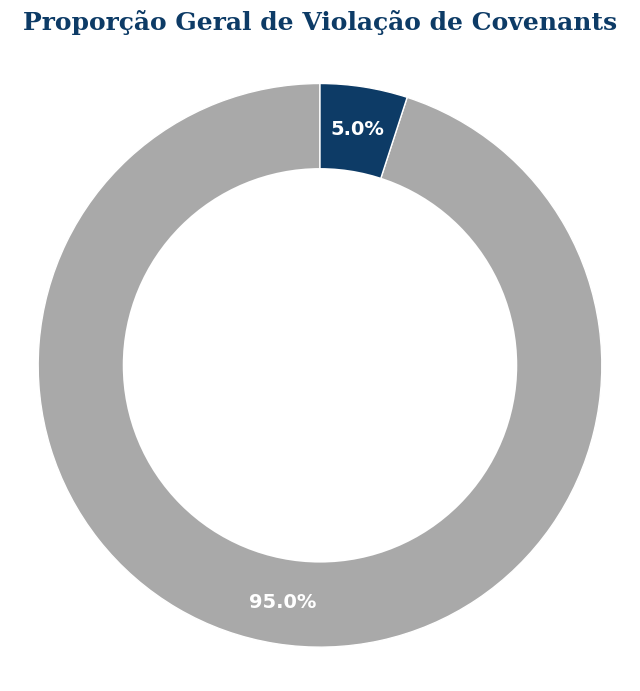

In [ ]:
# --- ESTÉTICA DO GRÁFICO ---
azul_escuro = "#0d3b66"
cinza_claro = "#a9a9a9"
font_titulo = {'family': 'serif', 'color': azul_escuro, 'size': 18, 'weight': 'bold'}
# --- FIM DA ESTÉTICA ---

# 1. Preparar os dados: contar as ocorrências de violação, removendo os nulos
contagem_violacao = df_filtrado['Violou?'].dropna().value_counts()

# 2. Plotagem do Gráfico de Rosca
plt.figure(figsize=(8, 8))
plt.pie(
    contagem_violacao,
    labels=contagem_violacao.index,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    colors=[cinza_claro, azul_escuro], # 'NÃO' em cinza, 'SIM' em azul
    wedgeprops=dict(edgecolor='white'),
    textprops={'color': 'white', 'fontweight': 'bold', 'fontsize': 14}
)

# Desenha o círculo no centro para criar o efeito de rosca
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Proporção Geral de Violação de Covenants', fontdict=font_titulo, pad=20)
plt.axis('equal')
plt.show()

#### 2. Quais Índices Têm a Maior Taxa de Violação?

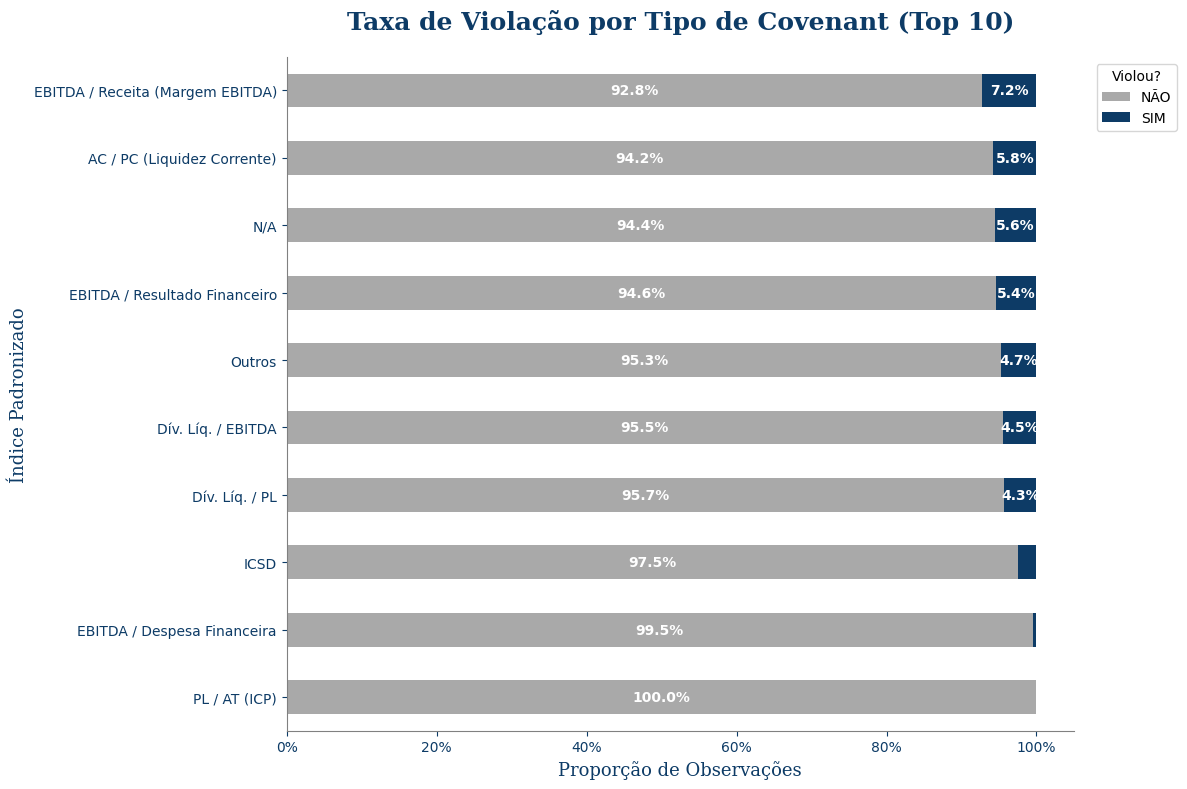

In [ ]:
# 1. Preparar os dados
df_analise = df_filtrado.dropna(subset=['Violou?', 'Indice_Padronizado_Final'])
top_10_indices = df_analise['Indice_Padronizado_Final'].value_counts().nlargest(10).index
df_analise_top10 = df_analise[df_analise['Indice_Padronizado_Final'].isin(top_10_indices)]

# 2. Criar tabela de contingência e normalizar
tabela_viol_indice = pd.crosstab(
    df_analise_top10['Indice_Padronizado_Final'], 
    df_analise_top10['Violou?'],
    normalize='index'
)
if 'SIM' not in tabela_viol_indice.columns: tabela_viol_indice['SIM'] = 0
tabela_viol_indice = tabela_viol_indice.sort_values(by='SIM', ascending=True)

# 3. Plotagem
ax = tabela_viol_indice[['NÃO', 'SIM']].plot(
    kind='barh',
    stacked=True,
    figsize=(12, 8),
    color=[cinza_claro, azul_escuro]
)

# Adiciona os rótulos de porcentagem
for p in ax.patches:
    width, height, x, y = p.get_width(), p.get_height(), p.get_x(), p.get_y()
    if width > 0.03:
        ax.text(x + width/2, y + height/2, f'{width:.1%}', ha='center', va='center', color='white', fontweight='bold')

plt.title('Taxa de Violação por Tipo de Covenant (Top 10)', fontdict=font_titulo, pad=20)
plt.xlabel('Proporção de Observações', fontdict=font_eixos)
plt.ylabel('Índice Padronizado', fontdict=font_eixos)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Violou?', bbox_to_anchor=(1.02, 1), loc='upper left')
sns.despine()
plt.tight_layout()
plt.show()

#### 3. Associação entre Categoria de Índice e Violação

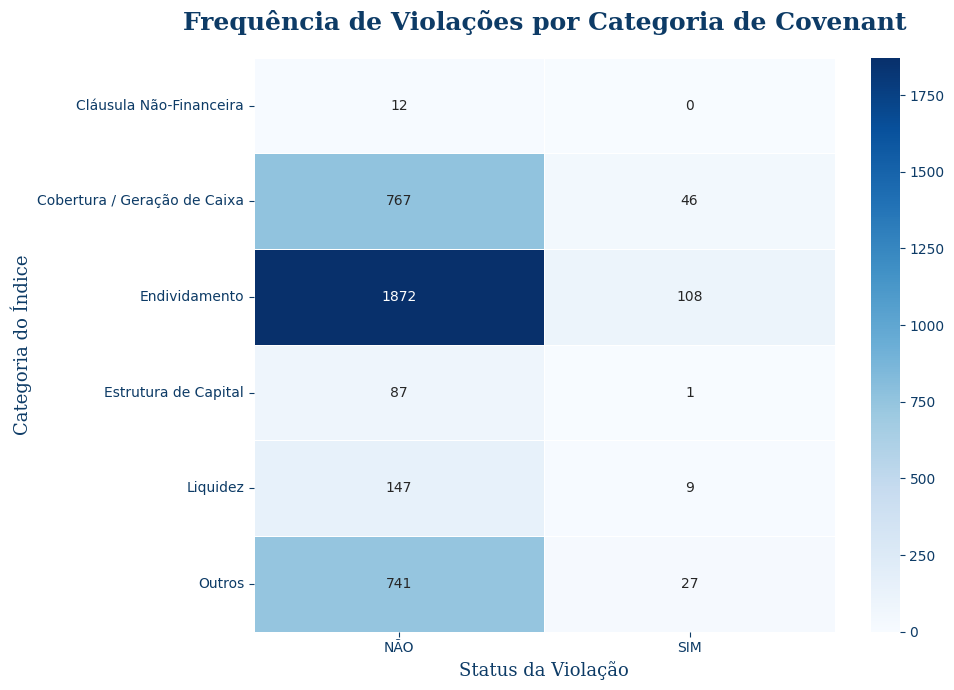

In [ ]:
# 1. Preparar os dados
df_analise_cat = df_filtrado.dropna(subset=['Violou?', 'Categoria_Indice'])

# 2. Criar tabela de contingência
tabela_cat_violacao = pd.crosstab(
    df_analise_cat['Categoria_Indice'], 
    df_analise_cat['Violou?']
)

# 3. Plotagem do Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    tabela_cat_violacao,
    annot=True,
    fmt='d', # Formato inteiro
    cmap='Blues',
    linewidths=.5,
    linecolor='white'
)

plt.title('Frequência de Violações por Categoria de Covenant', fontdict=font_titulo, pad=20)
plt.xlabel('Status da Violação', fontdict=font_eixos)
plt.ylabel('Categoria do Índice', fontdict=font_eixos)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## 🏢 5. **Setores mais expostos a covenants**

**Com a variável `Setor` adicionada**, você pode:

* Ver a proporção de empresas por setor que têm cláusulas de covenant.
* Quais setores mais divulgam os termos?
* Quais setores têm limites mais rígidos?
* Quais setores mais violam cláusulas?

📌 *Gráficos*: barras, heatmaps, scatterplots de valor do limite × setor.

#### 1. Empresas por setor na amostra

C:\Users\Maria Eduarda\AppData\Local\Temp\ipykernel_8564\1446711462.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




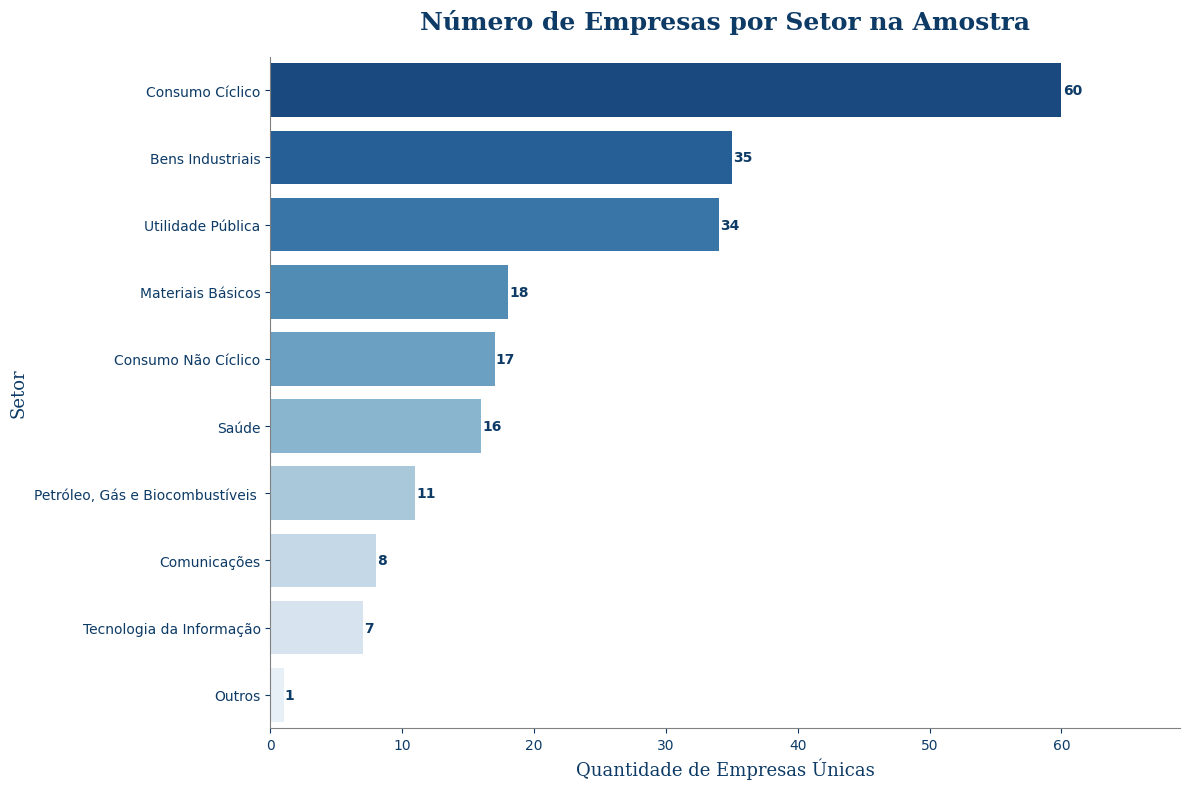

In [ ]:
empresas_por_setor = df_filtrado.groupby('Setor')['EMPRESA'].nunique().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x=empresas_por_setor.values,
    y=empresas_por_setor.index,
    palette="Blues_r"
)

# Adiciona os rótulos de dados
for i, v in enumerate(empresas_por_setor.values):
    ax.text(v + 0.1, i, str(v), color=azul_escuro, va='center', fontweight='bold')

plt.title('Número de Empresas por Setor na Amostra', fontdict=font_titulo, pad=20)
plt.xlabel('Quantidade de Empresas Únicas', fontdict=font_eixos)
plt.ylabel('Setor', fontdict=font_eixos)
plt.xlim(0, empresas_por_setor.max() * 1.15) # Espaço extra para os rótulos
sns.despine()
plt.tight_layout()
plt.show()

#### 2. Proporção de empresas por setor que divulgou cláusulas de covenant.

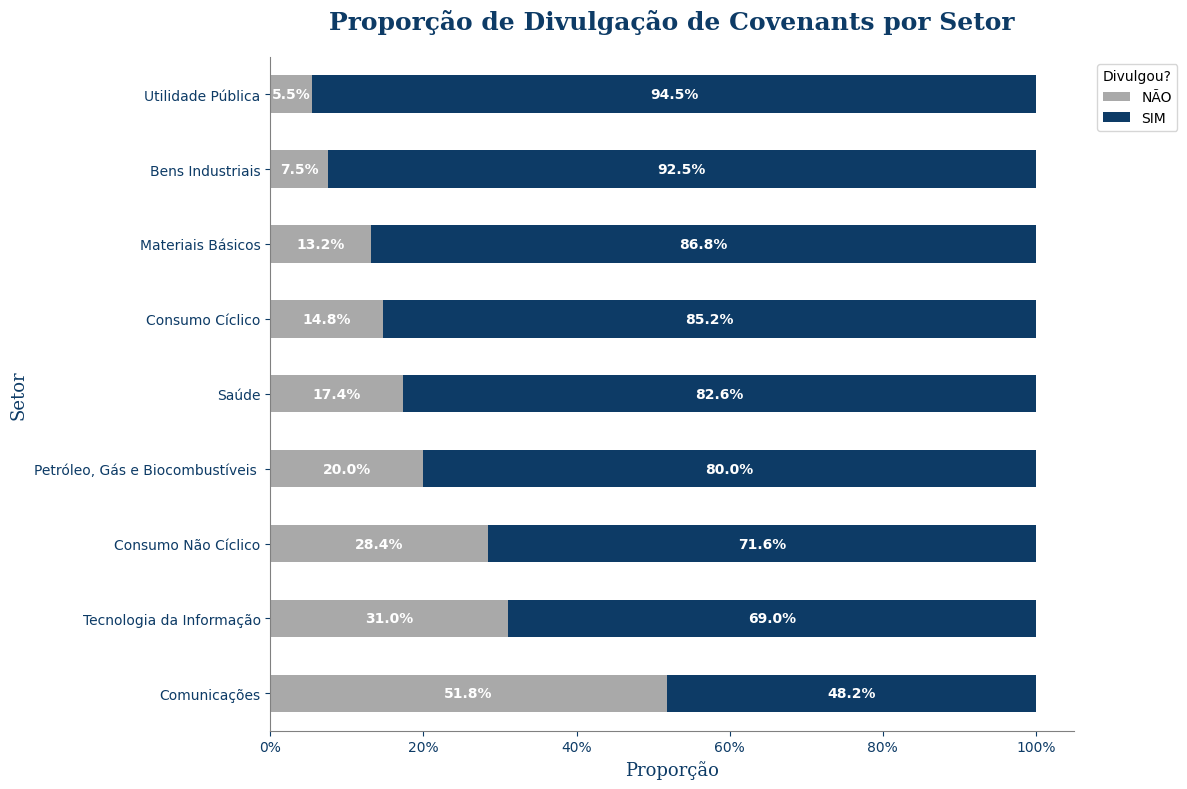

In [295]:
# Cria uma tabela de contingência
tabela_divulgacao = pd.crosstab(df_filtrado['Setor'], df_filtrado['DIVULGOU'], normalize='index')
tabela_divulgacao = tabela_divulgacao.sort_values(by='SIM', ascending=True)

# Normaliza a tabela para que a soma de cada linha seja 1 (100%)
tabela_norm = tabela_divulgacao.div(tabela_divulgacao.sum(axis=1), axis=0)

# Plotagem
ax = tabela_norm.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 8),
    color=['#a9a9a9', azul_escuro] # 'SIM' em azul, 'NÃO' em cinza
)

# Adiciona os rótulos de porcentagem
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if width > 0:
        ax.text(x + width/2,
                y + height/2,
                f'{width:.1%}', # Formata como porcentagem
                ha='center',
                va='center',
                color='white',
                fontweight='bold')

plt.title('Proporção de Divulgação de Covenants por Setor', fontdict=font_titulo, pad=20)
plt.xlabel('Proporção', fontdict=font_eixos)
plt.ylabel('Setor', fontdict=font_eixos)
plt.legend(title='Divulgou?', bbox_to_anchor=(1.02, 1), loc='upper left') # Legenda fora do gráfico
ax.xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format)) # Formata o eixo X como %
sns.despine()
plt.tight_layout()
plt.show()

#### Quais setores têm limites mais rígidos?

Comparar a rigidez dos covenants entre os setores, focando no indicador mais comum (Dív. Líq. / EBITDA), onde um limite menor é mais rígido.

C:\Users\PPGCC\AppData\Local\Temp\ipykernel_23348\2136962854.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_limites, y='Setor', x='valor_limite', order=medianas.index, palette='Blues_r')


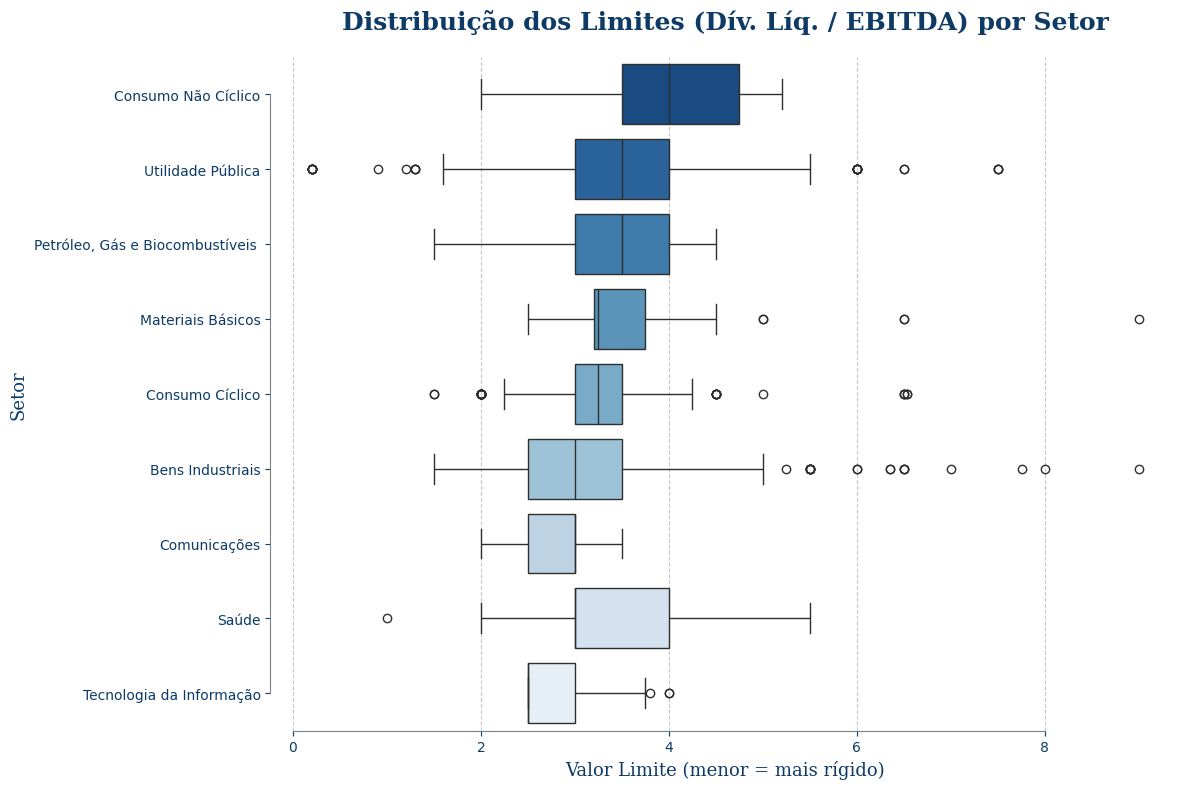

In [296]:
# 1. Filtrar dados para o índice de interesse
df_limites = df_filtrado[
    (df_filtrado['Indice_Padronizado_Final'] == 'Dív. Líq. / EBITDA') &
    (df_filtrado['valor_limite'].notna()) &
    (df_filtrado['valor_limite'] < 10)
].copy()

# 2. Calcular a mediana por setor para ordenar o gráfico
medianas = df_limites.groupby('Setor')['valor_limite'].median().sort_values(ascending=False)

# 3. Plotagem
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_limites, y='Setor', x='valor_limite', order=medianas.index, palette='Blues_r')

plt.title('Distribuição dos Limites (Dív. Líq. / EBITDA) por Setor', fontdict=font_titulo, pad=20)
plt.xlabel('Valor Limite (menor = mais rígido)', fontdict=font_eixos)
plt.ylabel('Setor', fontdict=font_eixos)
plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(trim=True)
plt.tight_layout()
plt.show()

Os setores de comunicações, saúde e tecnologia da informação demonstram uma notável padronização nos limites de seus covenants. A coincidência entre a mediana e um dos quartis (inferior ou superior) indica que uma grande proporção dos contratos nesses setores converge para um único valor central, sugerindo pouca dispersão nas condições de alavancagem negociadas pelas empresas.

#### Quais setores mais violam cláusulas?

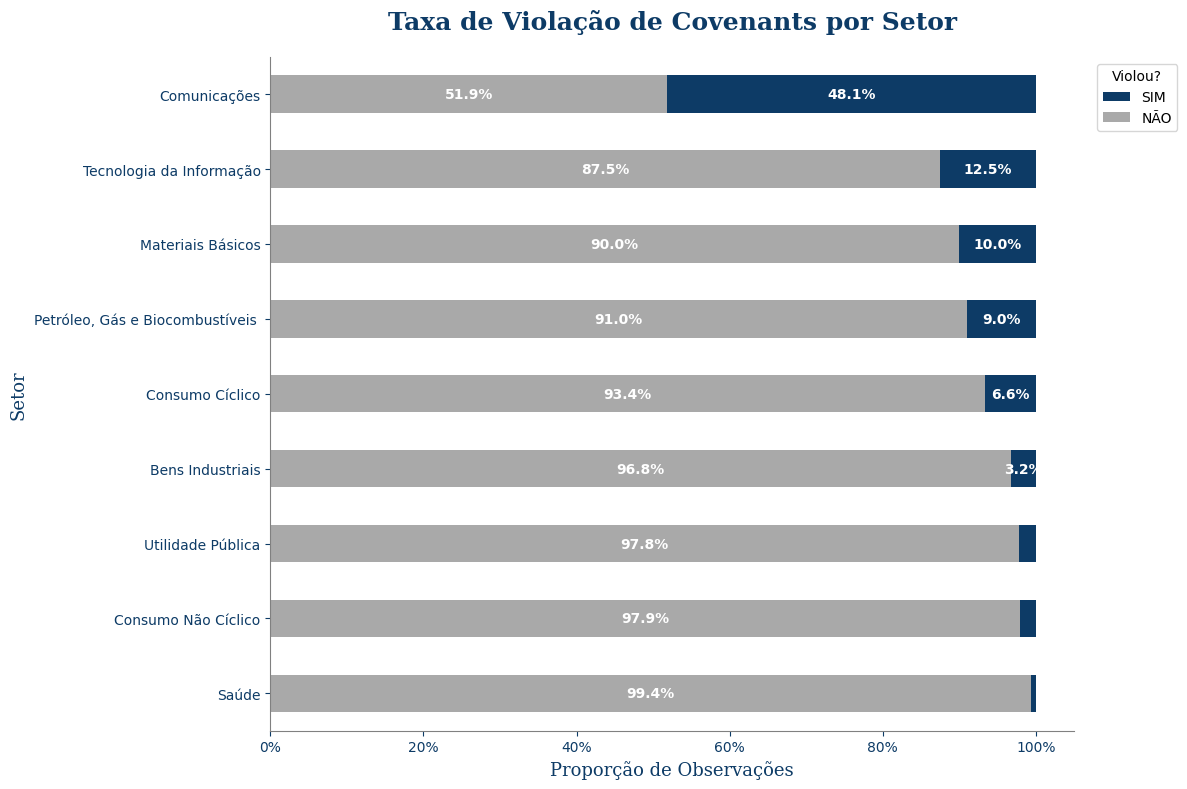

In [297]:
# 1. Criar tabela de contingência e normalizar
tabela_violou = pd.crosstab(df_filtrado['Setor'], df_filtrado['Violou?'], normalize='index')
if 'SIM' not in tabela_violou.columns: tabela_violou['SIM'] = 0
tabela_violou = tabela_violou.sort_values(by='SIM', ascending=True)

# 2. Plotagem
ax = tabela_violou[['NÃO', 'SIM']].plot(kind='barh', stacked=True, figsize=(12, 8), color=[cinza_claro, azul_escuro])

# Adiciona os rótulos
for p in ax.patches:
    width, height, x, y = p.get_width(), p.get_height(), p.get_x(), p.get_y()
    if width > 0.03:
        ax.text(x + width/2, y + height/2, f'{width:.1%}', ha='center', va='center', color='white', fontweight='bold')

plt.title('Taxa de Violação de Covenants por Setor', fontdict=font_titulo, pad=20)
plt.xlabel('Proporção de Observações', fontdict=font_eixos)
plt.ylabel('Setor', fontdict=font_eixos)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title='Violou?', bbox_to_anchor=(1.02, 1), loc='upper left')
sns.despine()
plt.tight_layout()
plt.show()


## 📅 6. **Evolução temporal**

**Se tiver a variável `ANO` bem preenchida**:

* Evolução do uso de covenants ao longo do tempo.
* Mudança nos limites definidos ano a ano.
* Tendência de divulgação e violação.

Objetivo de mostrar dinamismo na pesquisa, revelando como as práticas de mercado, a rigidez dos contratos e o comportamento das empresas mudaram ao longo dos anos.

#### 1. Evolução da composição dos covenants ao longo dos anos

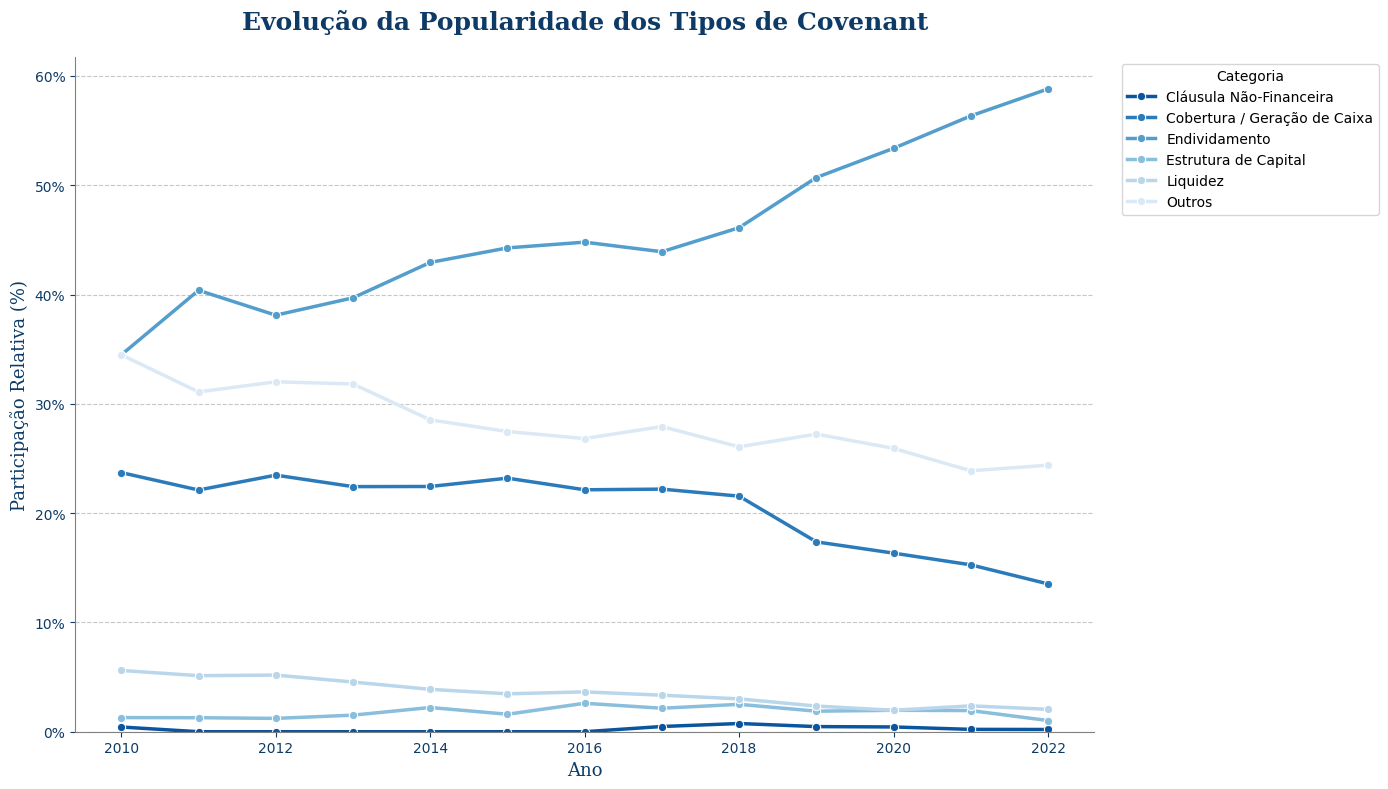

In [ ]:
# 1. Preparar os dados: criar tabela de contingência e normalizar por ano
tabela_ano_cat = pd.crosstab(
    df_filtrado['ANO'],
    df_filtrado['Categoria_Indice'],
    normalize='index'
)

# 2. "Derreter" (melt) a tabela para o formato longo, ideal para o seaborn
tabela_longa = tabela_ano_cat.reset_index().melt(
    id_vars='ANO',
    var_name='Categoria',
    value_name='Proporção'
)


# 3. Plotagem do Gráfico de Linhas Múltiplas
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=tabela_longa,
    x='ANO',
    y='Proporção',
    hue='Categoria',
    marker='o',
    linewidth=2.5,
    palette='Blues_r'
)

# Formata o eixo Y como porcentagem
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.title('Evolução da Popularidade dos Tipos de Covenant', fontdict=font_titulo, pad=20)
plt.xlabel('Ano', fontdict=font_eixos)
plt.ylabel('Participação Relativa (%)', fontdict=font_eixos)
plt.ylim(0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Categoria', bbox_to_anchor=(1.02, 1), loc='upper left')
sns.despine()
plt.tight_layout()
plt.show()

#### 2. Mudança na Rigidez dos Limites Ano a Ano

Metodologia e Gráfico Escolhido: Focaremos no principal covenant (Dív. Líq. / EBITDA). Um Gráfico de Linha com Intervalo de Confiança é ideal. Ele mostra a média do limite a cada ano (a linha) e a dispersão dos dados (a área sombreada), nos dando uma visão clara da tendência central e da variabilidade.

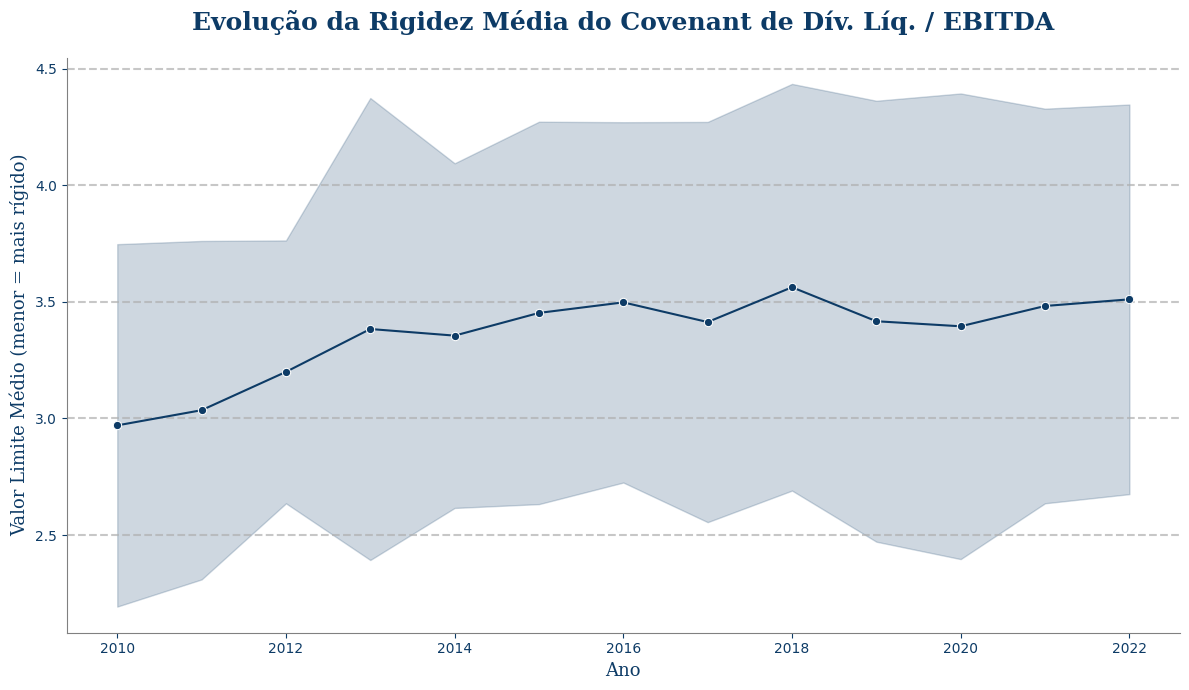

In [ ]:
# 1. Preparar os dados
df_limites_dl_ebitda = df_filtrado[
    (df_filtrado['Indice_Padronizado_Final'] == 'Dív. Líq. / EBITDA') &
    (df_filtrado['valor_limite'].notna()) &
    (df_filtrado['valor_limite'] < 10)
].copy()

# 2. Plotagem do Gráfico de Linha
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df_limites_dl_ebitda,
    x='ANO',
    y='valor_limite',
    marker='o',
    color=azul_escuro,
    errorbar='sd' # A área sombreada representa o desvio padrão
)

plt.title('Evolução da Rigidez Média do Covenant de Dív. Líq. / EBITDA', fontdict=font_titulo, pad=20)
plt.xlabel('Ano', fontdict=font_eixos)
plt.ylabel('Valor Limite Médio (menor = mais rígido)', fontdict=font_eixos)
plt.grid(axis='y', linestyle='--', alpha=0.7, linewidth=1.5)
sns.despine()
plt.tight_layout()
plt.show()

#### 3. Tendência de Divulgação e Violação ao Longo do Tempo

C:\Users\Maria Eduarda\AppData\Local\Temp\ipykernel_8564\2543997298.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\Maria Eduarda\AppData\Local\Temp\ipykernel_8564\2543997298.py:4: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



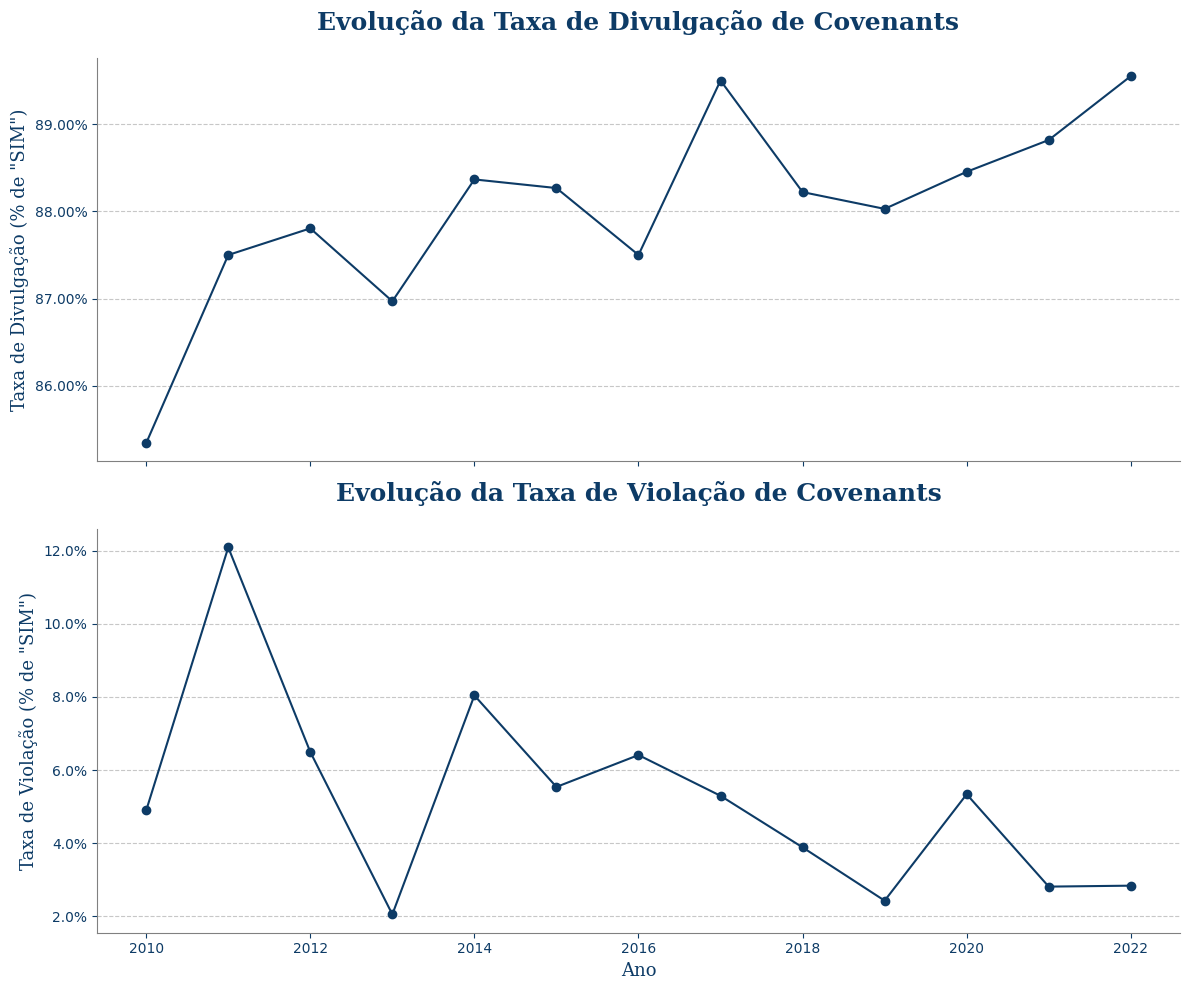

In [ ]:
# 1. Preparar os dados
# Converte SIM/NÃO para 1/0 para calcular a média (que será a proporção de 'SIM')
df_filtrado['Divulgou_num'] = df_filtrado['DIVULGOU'].replace({'SIM': 1, 'NÃO': 0})
df_filtrado['Violou_num'] = df_filtrado['Violou?'].replace({'SIM': 1, 'NÃO': 0})

taxa_divulgacao = df_filtrado.groupby('ANO')['Divulgou_num'].mean()
taxa_violacao = df_filtrado.groupby('ANO')['Violou_num'].mean()


# 2. Plotagem (em duas figuras separadas)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

# Gráfico de Divulgação
ax1.plot(taxa_divulgacao.index, taxa_divulgacao.values, marker='o', color=azul_escuro)
ax1.set_title('Evolução da Taxa de Divulgação de Covenants', fontdict=font_titulo, pad=20)
ax1.set_ylabel('Taxa de Divulgação (% de "SIM")', fontdict=font_eixos)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico de Violação
ax2.plot(taxa_violacao.index, taxa_violacao.values, marker='o', color=azul_escuro)
ax2.set_title('Evolução da Taxa de Violação de Covenants', fontdict=font_titulo, pad=20)
ax2.set_ylabel('Taxa de Violação (% de "SIM")', fontdict=font_eixos)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2.grid(axis='y', linestyle='--', alpha=0.7)

ax2.set_xlabel('Ano', fontdict=font_eixos)

sns.despine()
plt.tight_layout()
plt.show()



---

---

## 📚 8. **Discussão econométrica (opcional)**

Se tiver tempo e dados complementares:

* Você pode rodar uma regressão para **estimar a probabilidade de violação**, com variáveis como:

  * tipo de índice
  * setor
  * ano
  * valor do limite
  * tipo de instrumento (debênture vs empréstimo)

📌 *Modelo sugerido*: regressão logística.

---

## ✨ Exemplos de perguntas para seu artigo

* "Quais índices são mais usados como covenants nas empresas listadas da B3?"
* "Há setores que enfrentam cláusulas mais restritivas?"
* "Os limites definidos nos contratos mudaram com o tempo?"
* "As cláusulas são efetivas? Há alto índice de violação?"
* "Existe alguma evidência de que empresas com covenants apresentam melhor governança?
